지금까지 진행한 광고들을 바탕으로 새로운 광고의 일주일 소진율 예측

In [2]:
# 라이브러리 불러오기

import datetime
import pandas as pd
import numpy as np
import seaborn as sns

#pd.set_option('display.float_format', '{:.4f}'.format) # 소수점 둘째 자리까지 표시
#pd.set_option("display.max_rows", None)   # 모든 행 출력
pd.set_option("display.max_columns", None)  # 모든 열 출력
#pd.set_option("display.width", None)     # 줄바꿈 없이 넓게 출력
#pd.set_option("display.max_colwidth", None)  # 셀 안의 긴 내용도 다 출력

In [3]:
# 한글 오류 제거 

import platform
import matplotlib.pyplot as plt

# 1. 한글 폰트 설정
if platform.system() == 'Darwin':  # Mac
    plt.rcParams['font.family'] = 'AppleGothic'
elif platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:  # Linux (예: colab)
    plt.rcParams['font.family'] = 'NanumGothic'

# 2. 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

### 광고목록 데이터 불러오기 & 독립변수 추가

In [4]:
# 광고 목록 테이블 불러오기
ads_list = pd.read_csv("df_list_v1.csv", usecols=['ads_idx', 'ads_edate', 'aff_idx', 'ads_name', 'ads_type', 'ads_category', 'ads_save_way', 'ads_limit', 'ads_os_type', 'ads_payment', 'ads_summary', 'ads_rejoin_type'])
ads_list['ads_edate'] = pd.to_datetime(ads_list['ads_edate'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# 광고기간이 결측값인 행은 '2262-04-11'으로 채우기
# '2262-04-11' : pandas의 datetime64[ns]가 다룰 수 있는 범위
ads_list['ads_edate'] = ads_list['ads_edate'].fillna(pd.to_datetime("2262-04-11"))

# 제휴사 광고를 제외한 아이브 광고만 선택
ads_list = ads_list[ads_list['aff_idx'] == 1]

# 테스트 광고 수정 필요 -> 온리 테이트가 있다고 테스트 광고가 아님
is_test_ad = ads_list["ads_name"].str.contains("테스트|서비스종료|삭제", na=False, case=False)
is_valid_test_ad = ads_list["ads_name"].str.contains("브레인 테스트|게임테스트", na=False, case=False)
condition_to_delete = is_test_ad & ~is_valid_test_ad
ads_list = ads_list[~condition_to_delete].copy()

/var/folders/vr/q6052k192l5b8zc1yrwpz_fw0000gn/T/ipykernel_38412/3123888663.py:2: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  ads_list = pd.read_csv("df_list_v1.csv", usecols=['ads_idx', 'ads_edate', 'aff_idx', 'ads_name', 'ads_type', 'ads_category', 'ads_save_way', 'ads_limit', 'ads_os_type', 'ads_payment', 'ads_summary', 'ads_rejoin_type'])


In [5]:
# --- 분류 함수 (제외 키워드 적용) ---

def categorize_domain(df, domain_name, keywords, search_cols, exclude_keywords=None):
    """
    DataFrame의 지정된 열(search_cols)에서 키워드를 찾아 
    새로운 도메인을 부여하는 함수입니다. (제외 키워드 적용)
    
    Args:
        df (pd.DataFrame): 작업할 데이터프레임
        domain_name (str): 새로 부여할 도메인 이름 (예: '금융/보험')
        keywords (list): 찾을 키워드 리스트 (예: ['피싱', '보험'])
        search_cols (list): 키워드를 검색할 열 이름 리스트 (예: ['ads_name', 'ads_summary'])
        exclude_keywords (list, optional): 제외할 키워드 리스트 (예: ['고양이'])
        
    Returns:
        pd.DataFrame: 도메인이 추가된 데이터프레임
    """
    # 1. 키워드 리스트를 OR(|) 조건으로 묶어 하나의 검색 패턴으로 만듭니다.
    keyword_pattern = '|'.join(keywords)
    
    # 2. 검색할 모든 열을 대상으로 키워드가 포함되었는지 확인하는 전체 조건을 만듭니다.
    contains_keyword = df[search_cols].apply(
        lambda col: col.str.contains(keyword_pattern, na=False)
    ).any(axis=1)
    
    # 3. 제외 키워드가 있을 경우, 제외 키워드가 포함된 행을 False로 처리
    if exclude_keywords is not None and len(exclude_keywords) > 0:
        exclude_pattern = '|'.join(exclude_keywords)
        contains_exclude = df[search_cols].apply(
            lambda col: col.str.contains(exclude_pattern, na=False)
        ).any(axis=1)
    else:
        contains_exclude = pd.Series([False]*len(df), index=df.index)
    
    # 4. 'domain' 열이 비어있는(NaN) 행 중에서, 키워드가 포함되고, 제외 키워드는 포함되지 않은 행만 선택
    condition = (df['domain'].isna()) & (contains_keyword) & (~contains_exclude)
    
    # 5. 해당 행의 'domain' 열에 새로운 도메인 이름을 채워 넣습니다.
    df = df.copy()  # 원본 데이터 보호
    df.loc[condition, 'domain'] = domain_name
    
    print(f"✅ '{domain_name}' 카테고리 분류 완료! ({condition.sum()}개 적용, 제외 키워드: {exclude_keywords})")
    return df

# --- 함수 사용 예시 ---

# 0. 먼저 'domain' 열을 생성하고 NaN으로 초기화합니다.
ads_list['domain'] = np.nan

# 1. '금융/보험' 도메인 분류 실행 (제외 키워드: '고양이')
keywords_finance = ['금융','피싱', '보험', '주식', '펀드', '스탁', '신한', '머니트리카드', '공모주', 'KB', '업비트', '거래소', '환급금', '상조','더핀','증권','뱅크','보험료']
exclude_keywords_finance = ['고양이','차차차','중고차','Idle']
search_columns = ['ads_name', 'ads_save_way']
ads_list = categorize_domain(ads_list, '금융/보험', keywords_finance, search_columns, exclude_keywords=exclude_keywords_finance)


# 2. '게임' 도메인 분류 실행
keywords_game = [
    '게임', '스코어', '캐릭터', '서브퀘스트', '포커', '퍼즐', '라스트워', '피자 레디', 
    '복권', 'RAID', '머지아일랜더스', '키우기', 'Merge', 'Puzzle', '아케론', '다크엔젤',
    '악마단', 'RPG', '서바이벌', '라바', '모바일', '사전예약', '타이니팜', '이계밥', '타이쿤',
    '강쥐','2X','골목주방', '올바른고','철물파크','레벨','도달','달성','00점','원스토어','Idle','Lv.',
    '초이스 맞추기','클리어','에리어','빗썸','Complete','Tycoon','다이노 투 레이스','획득',
    '구역 해제','모으기','소울 로그','잠금 해제','외계 시대','좀비','붉은 도시', '코인피클', '디펜스', '디바인엣지','영웅줍줍','K데몬헌터스','조조의 꿈','편의점 정리왕 3D'
]
# 제외할 키워드 리스트를 정의합니다.
exclude_keywords_game = ['프리다이빙']

# 함수를 호출할 때 exclude_keywords 인자를 정확히 전달합니다.
ads_list = categorize_domain(
    ads_list, 
    '게임', 
    keywords_game, 
    search_columns, 
    exclude_keywords=exclude_keywords_game
)


# 3-1. '생활/쇼핑/이커머스_상품소비' 도메인 분류 실행
keywords_goods_consumption = [
    # 기존 키워드 유지 (삭제/수정 금지)
    # 식품/건강
    '로얄캐닌', '콜라겐', '흑염소', '콘드로이친', '비타민', '간식', '베지밀', '식품', '블랙마카', '절임배추', '뉴트리하루', '영양제', '천심련 아나파랙틴', '고려은단', '오쏘몰', '간장게장', '왕뚜껑 킹스브레이브', '헬스케어', '케어', '홈헬스',
    '바지락', '닭가슴살', '식단', '단백질', '제주농장', '진공포장', 'MSM', '글루타치온', '완도', '김',
    # 패션/뷰티
    '향수', '여신티켓', '화장품', '스나이델뷰티', '바바더닷컴', '팬츠',
    '목걸이', '가방', '슬링백', '반팔티', '보정속옷', '캔버스', '카프스킨', '립앤칙스', '멀티밤', '톤업크림', '크림샌드',
    # 리빙/인테리어
    '핸드타올', '방석', '오늘의집', '한샘몰', '바자르', '방향제', '네온라이트',
    '싱크대배수구', '배수통', '배수관', '방충망', '모기장', '하수구트랩', '도어스토퍼', '선반', '매트',
    # 디지털/가전
    'LG전자', '삼성닷컴', '몬스타기어', '몬스타pc스토어',' 전자',
    '공기청정기', '필터', '랜턴', '마사지기', '모기채', '카드단말기', '키오스크', '포스기', '터미널', '커피메이커', '드립포트', '전기그릴',
    # 반려동물
    '강아지', '애견', '고양이', '덴탈껌', '치약껌', '이동가방', '리터네코',
    # 기타 상품소비
    '연장체인', '대나무체인', '퍼퓸', '오드퍼퓸', '세트', '골프 퍼팩트맨', '부스터 마사지건', '알로에겔', '알로에', '폼클렌징', '영화할인권', '영화예매권', '보일러',
    # 신규 추가: 상품소비(구매) 관련 키워드
    '토스터기', '안마기', '티포트', '크림', '토너', '경주빵', '이어폰', '충전케이블', '베개', '카사바칩', '샘물', '에그트레이', '귀이개', '마사지건', '실내사이클', '분리수거함', '보조배터리', '밀대', '코인타올', '목난로',
    # 신규 추가: 샘플 데이터에서 추출된 상품소비(구매) 관련 키워드
    '토마스 풀 패밀리', '멀티 와이드 그릴', '뉴네이처 알티지오메가3파워', '황후지화', '다이어트커피', '체지방감소', '레오폴디 로봇청소기', '스텐밀폐용기', '그린바나나 정', '깐알밤', '아쿠아 부스트 옴므 올인원', '체중계', '빨래바구니', '쎈쏘팔메토', '순녹용 골드', '진공청소기', '다이렉트 다이어트N유산균', '발효흑삼고', '레몬밤 다이어트', '샤인 미스트', '요거트메이커', '피부관리기', '올포유', '캐리어', '에어 프라이어', '후라이팬', '오로라플러스플라즈마', '피톤치드 탈취제', '카무트 효소', '모로실', '쿨토시', '헤어 에센스', '와인잔', '접이식 카트', '홍삼정', '리챔', '돼지양념구이', '믹스웰 블랜더', '차전자피식이섬유분말스틱', '브랜드밀효소', '연어코프로테오글리칸프리미엄', '비타 이뮨 플래티넘 골드', '타우린L-아르기닌', '냄비', '셀 이펙터 세럼', '오트밀', '관절보단', '기억력개선', '스트롱 업 차전자피', '호박 진액', '발효홍삼 산삼배양근 활력진골드 앰플', '핸디스팀다리미', '코헴무선스팀다리미', '코힐밤', '마호가니 원형도마', '마호가니 사각도마', '에디번 전기 그릴', '멀티믹서기', '철갑상어 건강즙', '홍삼로얄젤리스틱', '6년근홍삼정에브리원', '로댕 쏘 화이트업 마스크팩', '이데베논 페롤릭 부스터 앰플', '발효구기자 차', '모로오렌지 C3G 프리미엄', '목동알탕', '목동 곤이알찜', '올플레임 IH 세라믹 후라이팬', '올플레임 IH 세라믹 궁중팬', '캐리어 기내용', '레디백', '헤어클리닉', '쎈류신에너지파워', '에브리원 헤어드라이어', '아쿠아 무드등가습기', '마뜨앙 여행용 기내형캐리어', '찹살떡', '설기', '퍼펙트 커버 쿠션''온열', '카트', '투표권', '가르시니아', '브로멜', '파인애플효소', '하루힘차', '여주해죽순돼지감자차', '당당컷', '라끄시안', '굿매너', '화장지', '뷰티앤소프트', '더화이트', '키친타올', '물티슈', '나틴다', '클렌징', '립스틱', '로션', '자연에서 온 녹차', '블랙앵거스', 'LA갈비', '소불고기', '돼지불고기', '라에스테', '퍼펙트 듀오', '샴푸', '트리트먼트', '드라이기', '인덕션', '에어프라이어', '세정티슈', '벌꿀', '헤어팩', '양말', '더플백', '진공 쌀통', '찜질박사', '주방세제', '세탁세제', '섬유유연제', '톱날과도', '기황단', '레몬즙', '오메가3', '락토페린', '브레인1088', '루테인', '허니로얄제리', '참진한 흑마늘', '칫솔', '이불', '패드', '바싹불고기', '냉감 패드', '냉감 바디필로우', '에어매쉬토퍼', '레몬자몽즙', '레자몽', '레티놀C', '짜장', '해물짬뽕', '홍삼진', '홍삼액진', '흑삼진액', '스팀 헤어팩', '헤어로스 세럼', '헤리티지', '셀 부스팅 니들', '카무트효소', '리놀렌산', '장어활력', '녹용', '아르기닌', '마카', '샬롱', '이지쿡', '글라스뷰', '스위스밀리터리', '이엔비', '인사덴탑', 'NMN', 'Tubble', '메디트리', '네이처프리', '코오롱제약', '보령파워', '코스모팜', '신꼬', '칸투칸', '독일 코겔', '햄토피아', '동의삼', '순수달', '밸런스어게인', '퍼니트', '맛다움', 'G마켓',
    # 신규 추가: 샘플 데이터 기반 추가 키워드 (기존 키워드와 중복 제외)
    '케라틴 키퍼', '액상 마그네슘', '콤부차', '복합유산균', '골드 앰플', '워터 글라이드', '프로바이오틱스', '유기농애사비스틱', '유기농레몬생강즙', '오트오브맘', '프로틴메이트', '아르간 에센스', '스트레이트 펌', '헤어앰플', '스프레이', '염모제', '귀리 오트오브맘', '쿠폰팩', '마늘후랑크', '동치미 물냉면', '곡물발효효소', '함흥냉면', '신라면', '치즈카츠', '천연펄프', '팔토시', '닭한마리 볶음탕', '캡슐세제', '팔목형', '손목형', '보양 추어탕', '귀리쌀죽', '선 스크린', '바른어묵', '우거지 뼈해장국', '소내장탕', '카무트 누룽지', '보풀제거기', '골드 등급 패키지', '실버 등급 패키지', '블랙 등급 패키지', '팥찜질팩', '규조토페인트','스탠드다리미',
    '가정용천국의계단','침구청소기','프랭클린 이염방지시트','젖병소독기','자차청정기','유럽미장',
    '규조토페인트','커리쉴', '루트 레미디', '스칼프 토닉', '프레시포레스트향', '소프트켄넬', '얼음조끼', 'homegrow', '창문열차단', '암막시트지', '발 받침대', '반팔 와이셔츠', '인감도장', '럭스엑스팟', '용가리', '목문용방문손잡이', '플로우아쿠아슈즈', '골프모자', '보스턴백', '건전지', '트램폴린', '남자셔츠', '쿠션커버', '오리젠사료오리지날', '골프피규어', '수면조끼', '베이포레소맥스', '쿠션', '볼마커', '라셀르간냉식', 'Modern High', '팜아크', '아크용접기', '바를 수딩 쿨링젤', '지아자연애장판', '유막제거제', '진정 앰플', '퍼팩트컴', '각인반지', '니트릴장갑', '부산국밥', '팰리세이드호환튜닝용품', '드리미 음식물처리기', '43인치스탠바이미', '휴나인 매스틱 검', '팰리세이드튜닝', '팰리세이드튜닝 c필러수납', '팰리세이드튜닝142', '팰리세이드 사이드스텝', '팰리세이드 쓰레기통 튜닝', '코인비엠에스', '갤럭시북K71AR', 'NT950XFT-A51A', '하주씨앤씨', '긱베이프 레전드3','루이보스티', '양배추즙', '토마토즙', '대추즙', '헛개진액', '수제청', '포스파티딜세린', '올리브오일', '미백마스크팩', '진정마스크팩', '유산균', '등산화깔창', '게이밍 컴퓨터의자', '디퓨저', '골프패치', '남자링거티', '기능성반팔 쿨 카라티', '즐거운가구 렌지대', 'NUTRALIFE 카테킨', '비엔엠코리아', '미마유모차', '에피소X', '블로커콤비블라인드', '엘리카', '벨벳', '엘라카테슬라', '테슬라', '오란다', '오토바이 자석 거치대', '바벨런스', '쿠션커버', '쿠션', '수면조끼', '팥찜질팩', '방수앞치마', '명함제작', '스티커제작', '드레이프블라우스', '꼬막', '방수앞치마', '유리문 도어락', '무타공 도어락', '모기퇴치기', '해충 퇴치기', 'Onliv', '잔더','롯데마트 제타', '락앤락', '동국제약', '닥터로니', '휴리엔', '백년약방', '네일로그', '안락의자', '리빙박스', '아이언커버', '와이셔츠', '블라우스', '한우사골곰탕', '곶감', 'usb', '청국장', '베누스타 청소기', '컴퓨터의자', '인테리어의자', '그로밋 키링', '해장국', '딸기칩', '개완', '티머그', '차총', '보이차', '구찌뽕 추출물', '백향과', '황토볼', '차열페인트', '곰팡이방지페인트', '결로방지페인트', '벽지페인트', '가정용미니에어건', '네오프렌구명조끼', '휴나인 애사비','삼성 G100','삼성 H170D','삼성 F100D','키친플래그','제주탄산수',
    # 신규 추가: 분석된 상품소비 키워드
    '밴디 양방향 미끄럼방지 실내 욕실화', '삼성제약 내간에밀크씨슬실리마린', 'US 스킨아우라히알루론비타', 'US 프로바이오포스콜리500', '부사 사과', '스테비아 방울토마토', '천도복숭아', '하우스 감귤', '청사과', '프리미엄 파로', '백골뱅이', '대추 방울토마토', 'vintage', '체리 운드', '밤꿀', '네오디움 자석', '쉬폰커튼', '암막커튼', '코드스트랩', '스와들', '셀프페인트', '젯소', '페인트', '친환경페인트', '마이크로시멘트', '휘게로 페인트', '베스트에어컨 투인원', '여성 여름 셔츠', '치약', '피톤치드', '나노건', '피톤치드연무기', 'LCN마이코셉트', '업젤', '닭갈비', '오리주물럭', '프로파일','전자담배','논가스용접기',
    # 신규 추가: 분석된 데이터에서 상품소비로 분류할 키워드
    '볶은아몬드', '무선 쿨링 고데기', '골프트로피', '스탠맨해머전동드릴', '블루키워드', '리브라 에보', '유산지어', '지오 24MR400W 지오비전', '개밥청춘 위픽 에어드', '테이블야자', '떡볶이택배', '구운계란', '엘카라 프로폴리스', '크리스탈 감사패', '커피원두', '인섹트도그', '미마 모카색상 절충형유모차', '여행용 프리볼트 고데기', '수술복', '갤럭시S25케이스', '꼬리곰탕', '아론샵 홀드맥스 헤어젤', '루피는 참치마요', '야채참치', '밀크팡 산양유프로틴', '대추차', '27US550', '윈도우11', '닥터스초이스 콘드', '자전거라이트어', '자바라의자', '스탠드스팀다리미', '스팀다리미', '구강세정기', '제본', '산삼', '식물등', '테라리움', '책상 스탠드', '슬릿분', '백일상대여', '출차주의등', '수모', '도라지청', '환갑현수막', '칠순현수막', '관리기', '결명자차', '구기자차', '보리차 원액',
    # 신규 추가: 100행 데이터에서 확실한 상품소비 키워드
    '구운아몬드', '캐슈넛', '임산부효소', '업소용청소기', '아기잠옷', '아기파자마', 'PPF 왁스', '실내수영복', '용융소금', '스캇나인 아구아헤', '스타리온 대형 45박스 올냉장 냉장고', '전자저울', '멜라토닌', '감사패', '장수돌침대', '골프마스크팩', '교구장', '체리', '코튼 폴로 반팔니트', '코튼 반팔 폴로 여름니트', '차거름망', '곰탕육수', '씽크어스 하트', '차판', '자숙문어', '메리네 라비앙독', '여성 반팔 셔츠', '샤인머스켓', '오토바이리스', '양갈비', '까렌다쉬샤프', '잔디깎기', '하수구 뚫는 기계', '메탈지그', '청양고추', '예초기', '배달오토바이리스', '오리젠사료', '시트지제작', '우정링', '커플팔찌', '홍삼음료', '클립온 선글라스', '노시부석션팁', '닥터커피', '아몬드', '안전벨트', '건강하삼', '햄스터 케이지', 'ab슬라이드', '숙취해소제', '삼성ssd', '석재볼라드', '마사지젤', '가죽스티커', '콘체 블렌더',
    # 신규 추가: 83행 데이터에서 확실한 상품소비 키워드
    '메이튼 맥세이프자동차거치대', '베베끌레르 퍼펙트제로', '리플렛', '어닝', '방수액', '스트레치필름', '오토바이자석거치대', '핸드워시 답례품', '가죽트레이', '아만', '휴대폰 맥세이프 마그네틱 투명케이스', '어그 밴딩 슬리퍼', '손톱강화제', '까렌다쉬 샤프', '메탈파일', '원두커피', '인형뽑기기계', '일본지게차', '피오렌자또', '씨메커피머신', '토삭스', '파고라', '패션뷰티몰', '세레스쥬얼리',
    '최대 77% 할인. 럭키세븐 특가','29cm', '상품찜','JONS 신규 가입 혜택','참소라', '글루어트', '새미쥬얼리', '조개구이', '초코파이','나물짤순이'
]
exclude_keywords_goods_consumption = ['연남동 스튜디오']
ads_list = categorize_domain(
    ads_list,
    '상품소비',
    keywords_goods_consumption,
    search_columns,
    exclude_keywords=exclude_keywords_goods_consumption
)

# 3-2. '생활/쇼핑/이커머스_생활서비스' 도메인 분류 실행
keywords_life_service = [
    # 기존 키워드 유지 (삭제/수정 금지)
    # 교육/부동산
    '교육', '학습', '영어', '보카', '홈런', '온리원', '부동산', '경매', '기출문제', '학원',
    # 여행/문화
    '호텔', '하나투어', '골프네임택', '스마트캐디', '프리다이빙',
    # 생활서비스
    '운동', '휘트니스', '테라피', '캠핑', '물구나무', '운동기구', '참여신청', '달다방',
    # 신규 추가: 회원가입(서비스) 관련 키워드
    '회원가입', '서비스 가입', '라이프플러스', '트라이브', 'H.Point 회원 가입하기',
    # 샘플 데이터에서 추출된 생활서비스 관련 키워드
    '공용 화장실 해제','이혼전문변호사',
    # 신규 추가: 샘플 데이터 기반 추가 키워드 (기존 키워드와 중복 제외)
    '최초 오픈', '기부완료', '쿠폰팩 가입', '인터넷신규가입','Shipping','패러글라이딩', '일상비일상의틈', 'NOL', 'NOL (신규회원 국내숙소 특별할인)', '최초 오픈', '정답입력',
    # 추가: 리뷰 전체보기 클릭 후 URL 제출, 스토어 알림받기, 명소찾기
    '리뷰 전체보기 클릭 후 URL 제출', '스토어 알림받기', '명소찾기',
    # 신규 추가: 분석된 생활서비스 키워드
    '상세페이지제작', '비상주사무실',  'V컬러링 이용권',
    # 신규 추가: 100행 데이터에서 확실한 생활서비스 키워드
    '로고제작',
    # 신규 추가: 83행 데이터에서 확실한 생활서비스 키워드
    '특수청소', '전단지배포및제작','바카르','젤톡스','SK브로드밴드'
]
exclude_keywords_life_service = []
ads_list = categorize_domain(
    ads_list,
    '생활서비스',
    keywords_life_service,
    search_columns,
    exclude_keywords=exclude_keywords_life_service
)

# 3-3. '생활/쇼핑/이커머스_플랫폼' 도메인 분류 실행
keywords_platform = [
    # 기존 키워드 유지 (삭제/수정 금지)
    '쿠팡', '아이템매니아', '중고거래', '백화점', '당근마켓', '동네GS', 'GS25', '배달의민족',
    # '네이버스마트스토어',
    # 샘플 데이터에서 추출된 플랫폼 관련 키워드
    'G마켓',
    # 신규 추가: 샘플 데이터 기반 추가 키워드 (기존 키워드와 중복 제외)
    '에누리 가격비교', '네이버 쇼핑', '네이버 상품 해시태그', '상품 태그 맞추기',
    # # 신규 추가: 분석된 플랫폼 키워드
    # '최대 77% 할인. 럭키세븐 특가',
    # # 신규 추가: 100행 데이터에서 확실한 플랫폼 키워드
    # '29cm', '상품찜',
    # # 신규 추가: 83행 데이터에서 확실한 플랫폼 키워드
    # 'JONS 신규 가입 혜택', '바카르'
]
exclude_keywords_platform = []
ads_list = categorize_domain(
    ads_list,
    '플랫폼',
    keywords_platform,
    search_columns,
    exclude_keywords=exclude_keywords_platform
)

# 아래는 분류가 애매하거나 추가 검토가 필요한 항목 리스트입니다.
# 분류가 애매한 항목 (키워드로 분류가 어려운 경우)
# - 퀴즈 맞추기, 퀴즈 정답 맞추기, [퀴즈] ~, ~맞추기, [정답] ~, 클릭, 받기, 상세페이지제작, 대전 비상주사무실, [간편참여] 특가요정, 강재인 (저장 후 주차장 URL), 다이아XXXX (저장 후 주차장 URL), 푸슈 (저장 후 주차장 URL), 일산보청기 (저장 후 주차장 URL), 미사 피부과 병원 미엘 (저장 후 주차장 URL), 수원중고차 (저장 후 주차장 URL), 인천제일바다낚시 (저장 후 주차장 URL), 라플로르드무아 (저장 후 주차장 URL), 창원세무사 조영빈 사무소 (저장 후 주차장 URL), 대전유리창청소 (저장 후 주차장 URL), 부천한방병원 차오름 (명소찾기), 강남수입차정비 내화모터스 (명소찾기), 이리와코리아 10개옵션 맞추기, 피지컬방이헬스 맞추기, 논가스용접기 200프로 맞추기, 유산지어 맞추기, 테이블야자 맞추기, 떡볶이택배 맞추기, 구운계란 인생 맞추기, 개밥청춘 위픽 에어드 맞추기, 우주인전자담배 맞추기, 지오 24MR400W 지오비전 맞추기, 엘카라 프로폴리스 맞추기, 크리스탈 감사패 맞추기, 인섹트도그7.5kg 맞추기, 잘봄XXX (저장 후 주차장 URL), [퀴즈] 강남 하수구뚫음, 삼성 F100D, 닥터초이스맞추기, 볶은아몬드, [퀴즈] 금천구 하수구막힘, 습자지 맞추기, [퀴즈] 무선 쿨링 고데기, 좋은상패26 닷컴 골프트로피 맞추기, 스탠맨해머전동드릴 맞추기, 블루키워드 맞추기, 동동마켓 리브라 에보 맞추기, 전자담배 액상(미성년자불가미션), 커피원두 맞추기, 상세페이지제작, 대전 비상주사무실, [정답] 치약(네이버 상품 상세내용) 등은 명확한 카테고리 분류가 어려워 추가 검토 필요
# - 닥터초이스맞추기, 삼성 F100D, 볶은아몬드, [퀴즈] 금천구 하수구막힘, 습자지 맞추기, [퀴즈] 무선 쿨링 고데기, 좋은상패26 닷컴 골프트로피 맞추기, 스탠맨해머전동드릴 맞추기, 블루키워드 맞추기, 동동마켓의 엘리카 핏 83 맞추기, 동동마켓의 엘리카 핏 60 맞추기, 동동마켓 리브라 에보 맞추기, 동동마켓 엘리카 니콜라테슬라 벨벳83 맞추기, 동동마켓의 벨벳60 맞추기, 동동마켓 엘라카테슬라 맞추기, 동동마켓 4구엘리카 테슬라 맞추기, 피지컬방이헬스 맞추기, 이리와코리아 10개옵션 맞추기, 미마유모차 절충형유모차 맞추기, 논가스용접기 200프로 맞추기, 유산지어 맞추기, 테이블야자 맞추기, 떡볶이택배 맞추기, 구운계란 인생 맞추기, 기능성반팔 쿨 카라티 무지 맞추기, 즐거운가구 렌지대1800 맞추기, NUTRALIFE 카테킨 맞추기, 비엔엠코리아 10개옵션 맞추기, 오란다, 바벨런스, 골프패치, 남자링거티, 지오 24MR400W 지오비전 맞추기, 우주인전자담배 맞추기, 등산화깔창, 진정마스크팩, 미백마스크팩, 유산균, 디퓨저, 양배추즙, 토마토즙, 대추즙, 헛개진액, 수제청, 포스파티딜세린, 올리브오일, 게이밍 컴퓨터의자, 꼬막, 방수앞치마, 유리문 도어락, 무타공 도어락, 모기퇴치기, 해충 퇴치기, 드레이프블라우스, 명함제작, 스티커제작, 잔더, Onliv, 스토어 알림받기, 아이티시스템 (저장 후 주차장 URL), 강재인 (저장 후 주차장 URL), 인천이혼전문변호사 (저장 후 주차장 URL), 다이아XXXX (저장 후 주차장 URL), 푸슈 (저장 후 주차장 URL), 일산보청기 (저장 후 주차장 URL), 미사 피부과 병원 미엘 (저장 후 주차장 URL), 수원중고차 (저장 후 주차장 URL), 인천제일바다낚시 (저장 후 주차장 URL), 라플로르드무아 (저장 후 주차장 URL), 창원세무사 조영빈 사무소 (저장 후 주차장 URL), 대전유리창청소 (저장 후 주차장 URL), 부천한방병원 차오름 (명소찾기), 강남수입차정비 내화모터스 (명소찾기), 에피소X XX출 (저장 후 주차장 URL), [간편참여] 특가요정, 락앤락 첫구매 이벤트, 상세페이지제작, 대전 비상주사무실
# Mr.Shipping (ads_name: Mr.Shipping, ads_save_way: 참여) : 어떤 카테고리인지 불분명, 추가 검토 필요
# Travel 포캐스트, 헬씨 포캐스트 (ads_save_way: 결제 및 콘텐츠 이용) : 콘텐츠/여행/서비스 등 복합적, 추가 검토 필요
# 사주링 맞추기, 닥터초이스맞추기, 스탠드다리미, 가정용천국의계단, 침구청소기, 패러글라이딩, 습자지 맞추기, 프랭클린 이염방지시트 맞추기, 해님 젖병소독기 맞추기, 해님UVLED젖병소독기4세대 맞추기, 에어힐러자차청정기 맞추기, 유럽미장, 유럽미장셀프, 규조토페인트, 등 "퀴즈 맞추기"류 : 콘텐츠/앱테크/기타 등 분류 애매, 추가 검토 필요
# 강재인, 인천이혼전문변호사, 다이아XXXX, 푸슈, 에피소X 등 (ads_save_way: 퀴즈 정답 맞추기, ads_name에 (저장 후 주차장 URL) 포함) : 분류 불명확, 추가 검토 필요
# - Mr.Shipping (참여, ads_name: Mr.Shipping) : 어떤 카테고리인지 불분명, 추가 검토 필요


# 5.'SNS/커뮤니케이션' 도메인 분류 실행
keywords_sns = ['페이스북', '인스타', '채팅', '친구', '동네', '소개팅', '데이팅', '골드스푼', '여보야', '팬더티비', '상담', '라임', '카페', '카카오톡', '후엠아이','여보랑','비긴즈','커넥트 CONNECT']
exclude_keywords_sns = []
ads_list = categorize_domain(ads_list, 'SNS/커뮤니케이션', keywords_sns, search_columns, exclude_keywords=exclude_keywords_sns)


# 7.'콘텐츠' 도메인 분류 실행
keywords_content = ['탑툰', '웹툰', '미툰', '미노벨', '운세', '워치페이스', '파일썬', '웹하드', '애니툰', '포춘텔러','꿀밤티비', '꿀물티비', '핑크티비','토정비결','굿툰','TikTok','나의 커리어 DNA','천신','성향매핑', '커플케미', '영화리뷰','멜론팔로우', '궁합', '포춘쿠키','홀스브릿지','영화 보스','회원가입 후 결제','KWDA','투표권 +','포캐스트','사주']
exclude_keywords_content = []
ads_list = categorize_domain(ads_list, '콘텐츠', keywords_content, search_columns, exclude_keywords=exclude_keywords_content)

# 8. '앱테크/리워드' 도메인 분류 실행
keywords_apptech = ['앱테크', '돈버는', '리워드어플', '오토링', '짤', '아이부자', 'Cash Giraffe', 'Cash Cow', '파블로', '서베이','MyB','돈 버는 미션','판도라박스', '도형그리기', '박스찾기', '시간잡기','서베이']
exclude_keywords_apptech = []
ads_list = categorize_domain(ads_list, '앱테크/리워드', keywords_apptech, search_columns, exclude_keywords=exclude_keywords_apptech)


# 10. '유틸리티/툴' 도메인 분류 실행
keywords_util = ['통화녹음', '익시오', 'AI', '뤼튼', '구독', '체크플러스']
exclude_keywords_util = []
ads_list = categorize_domain(ads_list, '유틸리티/툴', keywords_util, search_columns, exclude_keywords=exclude_keywords_util)

# 11. '지역/상점' 도메인 분류 실행
keywords_local = ['맛집', '식당', '점', '시장', '휘트니스', '쭈앤쭈', '족발선생',
'소곱판','박가네 빈대떡','풍년옥','철판집','청류','지도','플레이스','연남동',
'방이별관','카카오맵','공항', '클럽', '스튜디오','잠실','그래한의원','신의주찹쌀순대','라 스위스 서촌',
'의원','PT 청라','숙성회','서촌', '한의원', '순대', '쭈꾸미', '막국수','포항', '계곡', '테라피','캄왁싱','이지은웨딩','제주 이모카세',
'수성구 치과', '강남 하수구뚫음', '두정역 메이크업 속눈썹', '불당동 윤곽관리', '봉선동돼지갈비','제주 장어정식', '광주 첨단 갈매기살', '제주 외도동 물회', '외도동 횟집' ,'대전유리창청소', '한남동 인터내셔널 필라테스' , '수원중고차',
# 신규 추가: 미분류 데이터에서 추출된 지역/상점 키워드
'치과', '고깃집', '술집', '이자카야', '헬스장', '케이크', '가족사진', '맞춤정장', '요트투어', '보청기', '피부과', '병원', '미엘', '바다낚시', '세무사', '사무소', '유리창청소', '한방병원', '수입차정비', '모터스', '냉면', '숙성명작', '평양냉면', '여수', '구미', '충주', '용산', '광안리', '진주', '가좌', '칠암동', '진해', '초천동', '진주혁신도시', '굴포천역', '수원역', '강서', '가정동', '일산', '인천', '달항아리', '청라', '부산', '동래역', '랍스타', '고양시', '중앙로', '노량진고시원', '안양 정형외과', '대구 정형외과', '경산시 중산동', '연남 초야', '구리 비뇨기과', '피지컬방이헬스', '경남 아파트']
exclude_keywords_local = []
ads_list = categorize_domain(
    ads_list, 
    '지역/상점', 
    keywords_local, 
    search_columns, 
    exclude_keywords=exclude_keywords_local
)

# 12. '기타' 도메인 분류 실행
# 기타 내부에 속하는 도메인 -> 보안, 뉴스
keywords_etc = ['뉴스','충청남도','다함께차차차','피싱', 'OTP', '안심', '스마트사인', '인증', '범죄알리미', '약속번호','원키퍼','렌트카',
'로그인보호서비스','차차차','보호','사람인','리본카','보안플러스','건강지키미','종합광고대행사','캐디톡','인크루트','네이버맵','정답 미션','붙임머리', '치료', '블로그', '마케팅','제로네이트','법무사','알바천국', '알바몬', '인터넷가입', '누수', '국무조정실','국가', '붙임머리', '치료', '블로그', '마케팅', '입주청소']
exclude_keywords_etc = []
ads_list = categorize_domain(
    ads_list,
    '기타',
    keywords_etc,
    search_columns,
    exclude_keywords=exclude_keywords_etc
)

# 이제까지 분류되지 않은(nan) 모든 행을 '기타'로 할당합니다.
ads_list.loc[ads_list['domain'].isna(), 'domain'] = '기타'


# --- 최종 결과 확인 ---
print("\n--- 분류되지 않은 데이터 개수 ---")
print(f"미분류 데이터: {ads_list['domain'].isna().sum()}개")

print("\n--- 전체 도메인 분류 현황 ---")
print(ads_list['domain'].value_counts())



print("\n--- 각 도메인별 샘플 데이터 ---")
for domain in ads_list['domain'].dropna().unique():
    print(f"\n✅ '{domain}'으로 분류된 데이터:")
    sample_data = ads_list[ads_list['domain'] == domain][['ads_name', 'domain']].head()
    print(sample_data)

/var/folders/vr/q6052k192l5b8zc1yrwpz_fw0000gn/T/ipykernel_38412/539223651.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '금융/보험' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[condition, 'domain'] = domain_name


✅ '금융/보험' 카테고리 분류 완료! (113개 적용, 제외 키워드: ['고양이', '차차차', '중고차', 'Idle'])
✅ '게임' 카테고리 분류 완료! (898개 적용, 제외 키워드: ['프리다이빙'])
✅ '상품소비' 카테고리 분류 완료! (1057개 적용, 제외 키워드: ['연남동 스튜디오'])
✅ '생활서비스' 카테고리 분류 완료! (269개 적용, 제외 키워드: [])
✅ '플랫폼' 카테고리 분류 완료! (8개 적용, 제외 키워드: [])
✅ 'SNS/커뮤니케이션' 카테고리 분류 완료! (99개 적용, 제외 키워드: [])
✅ '콘텐츠' 카테고리 분류 완료! (18개 적용, 제외 키워드: [])
✅ '앱테크/리워드' 카테고리 분류 완료! (13개 적용, 제외 키워드: [])
✅ '유틸리티/툴' 카테고리 분류 완료! (98개 적용, 제외 키워드: [])
✅ '지역/상점' 카테고리 분류 완료! (47개 적용, 제외 키워드: [])
✅ '기타' 카테고리 분류 완료! (19개 적용, 제외 키워드: [])

--- 분류되지 않은 데이터 개수 ---
미분류 데이터: 0개

--- 전체 도메인 분류 현황 ---
domain
기타            1822
상품소비          1057
게임             898
생활서비스          269
금융/보험          113
SNS/커뮤니케이션      99
유틸리티/툴          98
지역/상점           47
콘텐츠             18
앱테크/리워드         13
플랫폼              8
Name: count, dtype: int64

--- 각 도메인별 샘플 데이터 ---

✅ '기타'으로 분류된 데이터:
          ads_name domain
11     데저트 스톰: 걸프전     기타
15  오늘도 환생 차원의 기사단     기타
16      로스트테일(AOS)     기타
17      로스트테일(IOS)     기타
26        

/var/folders/vr/q6052k192l5b8zc1yrwpz_fw0000gn/T/ipykernel_38412/539223651.py:23: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  lambda col: col.str.contains(keyword_pattern, na=False)


In [6]:
# 광고 단계별 분류

conditions = [
    # 3단계: 최종 수익 창출 (구매, 게임(특정퀘스트))
    (ads_list['ads_type'].isin([9, 12])) | (ads_list['ads_category'].isin([5, 6, 10, 11])),
    # 2단계: 행동 유도 (설치, 실행, 참여, 퀴즈, 구독 등)
    (ads_list['ads_type'].isin([1, 2, 3, 7, 11])) | (ads_list['ads_category'].isin([1, 2, 3, 4, 7, 8])),
    # 1단계: 단순 노출 및 클릭
    (ads_list['ads_type'].isin([4, 5, 6, 8, 10]))
]
values = [3, 2, 1]

# 새로운 컬럼 생성
ads_list['ads_3step'] = np.select(conditions, values, default=0)

In [7]:
# ads_os_type : (7:웹) -> 1, (그외:앱) -> 0

ads_list['ads_os_type'] = ads_list['ads_os_type'].apply(lambda x: 1 if x==7 else 0).astype(int)

In [8]:
# ads_payment

import re

# 1. 단순 유료 광고 식별
is_unspecified_paid = ads_list['ads_payment'].astype(str).str.contains('유료|구매|결제', na=False)

# 2. 만,천 단위 변환 함수
def convert_korean_units(text):
    text = str(text)
    if '만' in text:
        number = re.search(r'\d+', text)
        return int(number.group()) * 10000 if number else text
    elif '천' in text:
        number = re.search(r'\d+', text)
        return int(number.group()) * 1000 if number else text
    return text

ads_list["ads_payment"] = ads_list["ads_payment"].apply(convert_korean_units)

# 3. 정규표현식을 통한 괄호, 문자 등 제거
# r'\(.*?\)'는 괄호와 괄호 안의 내용을 제거
# r'[^0-9.]'는 숫자 외의 모든 글자를 제거
ads_list["ads_payment"] = ads_list["ads_payment"].astype(str).str.replace(r'\(.*?\)', '', regex=True)
ads_list["ads_payment"] = ads_list["ads_payment"].str.replace(r'[^0-9.]', '', regex=True)

# 4. 숫자형이 아닌 값들을 NaN으로 변환 (to_numeric함수는 문자형이 아닌 값들을 숫자형으로 변환, errors='coerce'는 변환 불가한 값들을 NaN으로 변환)
ads_list["ads_payment"] = pd.to_numeric(ads_list["ads_payment"], errors='coerce')

ads_list['ads_payment'] = ads_list['ads_payment'].fillna(0).astype(float)

In [9]:
# 광고 길이 컬럼 추가

ads_list['ads_length'] = ads_list['ads_summary'].str.len()

In [10]:
# 나이제한, 성별 제한

import re

# 결측값 제거
ads_list['ads_limit'] = ads_list['ads_limit'].fillna('제한없음')

# 나이 관련 제한 추가 (제한O : 1, 제한X : 0)
age_pattern = re.compile(r'(\d+세|\d+대|\d+~\d+세|\d세+~\d+세)')
ads_list['age_limit'] = ads_list['ads_limit'].astype(str).apply(lambda x: 1 if re.search(age_pattern, x) else 0).astype(int)

# 성별 관련 제한 추가 (제한O : 1, 제한X : 0)
gender_pattern = re.compile(r'(남성|여성|남녀)')
ads_list['gender_limit'] = ads_list['ads_limit'].astype(str).apply(lambda x: 1 if re.search(gender_pattern, x) else 0).astype(int)

### 아이브1년치_참여데이터 불러오기

In [11]:
# 참여데이터 불러오기
ive_time_report = pd.read_csv("df_rpt_clean.csv")
ive_time_report['rpt_time_date'] = pd.to_datetime(ive_time_report['rpt_time_date'], format='%Y-%m-%d', errors='coerce')

# 클릭수보다 전환수가 더 많은 행 제거하기
ive_time_report = ive_time_report[ive_time_report['rpt_time_clk'] >= ive_time_report['rpt_time_turn']]

# 참여데이터 날짜별로 그룹화하기
ive_time_report = ive_time_report.groupby(['rpt_time_date', 'ads_idx', 'mda_idx'], as_index=False).agg({'rpt_time_clk': 'sum', 'rpt_time_turn':'sum', 'rpt_time_acost':'sum', 'rpt_time_earn':'sum'})

ive_time_report['ads_idx'].nunique()

234430

### 전처리한 아이브1년치_참여데이터에 독립변수 만들기

In [12]:
filled_ive_time_report = ive_time_report.copy()

In [13]:
# 매체별 평균 광고 단가 (acost)
# 현재 행의 값은 포함하지 않고 이전 단가까지만 포함
# 그룹의 크기가 1보다 클 때만 계산하고, 1일 경우에는 0으로 채워줌

filled_ive_time_report['mda_mean_acost'] = (
    filled_ive_time_report.groupby('mda_idx')['rpt_time_acost']
      .transform(lambda x: x.shift().expanding().mean())
)

filled_ive_time_report['mda_mean_acost'] = filled_ive_time_report['mda_mean_acost'].fillna(0)

In [14]:
# 매체별 평균 매체사 단가 (earn)
# 현재 행의 값은 포함하지 않고 이전 단가까지만 포함
# 그룹의 크기가 1보다 클 때만 계산하고, 1일 경우에는 0으로 채워줌

filled_ive_time_report['mda_mean_earn'] = (
    filled_ive_time_report.groupby('mda_idx')['rpt_time_earn']
      .transform(lambda x: x.shift().expanding().mean())
)

filled_ive_time_report['mda_mean_earn'] = filled_ive_time_report['mda_mean_earn'].fillna(0)

In [15]:
# 매체별 평균 클릭수, 전환수 컬럼 만들기
# 현재 행의 값은 포함하지 않고 이전 클릭수, 전환수만 포함


# 매체별 과거까지의 클릭수 평균
filled_ive_time_report['mda_mean_clk'] = (
    filled_ive_time_report.groupby('mda_idx')['rpt_time_clk']
      .transform(lambda x: x.shift().expanding().mean())
)

# 매체별 과거까지의 전환수 평균
filled_ive_time_report['mda_mean_turn'] = (
    filled_ive_time_report.groupby('mda_idx')['rpt_time_turn']
      .transform(lambda x: x.shift().expanding().mean())
)

# 평균은 첫 값이 결측치로 저장됨
# 따라서 결측치는 0으로 저장

filled_ive_time_report[['mda_mean_clk','mda_mean_turn']] = (
    filled_ive_time_report[['mda_mean_clk','mda_mean_turn']].fillna(0)
)

In [16]:
# 매체별 누적 광고 비용 비율

# 현재 행을 제외한 과거까지의 광고 비용
filled_ive_time_report['mda_cum_acost'] = (
    filled_ive_time_report.groupby('mda_idx')['rpt_time_acost']
      .transform(lambda x: x.cumsum() - x)
)

# 현재 행을 제외한 과거까지의 전체 누적 비용
filled_ive_time_report['global_cum_acost'] = filled_ive_time_report['rpt_time_acost'].cumsum() - ive_time_report['rpt_time_acost']

# 현재 행을 제외한 매체별 비용 비율
filled_ive_time_report['mda_cost_ratio'] = (
    (filled_ive_time_report['mda_cum_acost'] / filled_ive_time_report['global_cum_acost']).fillna(0)
)

filled_ive_time_report = filled_ive_time_report.drop(['mda_cum_acost', 'global_cum_acost'], axis=1)

In [17]:
# 월 컬럼 추가하기

filled_ive_time_report['month'] = filled_ive_time_report['rpt_time_date'].dt.month

In [18]:
# 분기 컬럼 추가하기
filled_ive_time_report['quarter'] = (filled_ive_time_report['month'] - 1) // 3 + 1

In [19]:
# 월초, 월말 컬럼

# '월초' 컬럼 생성 (날짜가 10일 이하이면 1, 아니면 0)
filled_ive_time_report['is_month_start'] = (filled_ive_time_report['rpt_time_date'].dt.day <= 10).astype(int)

# '월말' 컬럼 생성 (날짜가 25일 이상이면 1, 아니면 0)
filled_ive_time_report['is_month_end'] = (filled_ive_time_report['rpt_time_date'].dt.day >= 25).astype(int)

In [20]:
# 평일에 공휴일이 있는 주차 표시

import holidays

# 대한민국 공휴일 데이터
kr_holidays = holidays.KR(years=[2024, 2025])

# 날짜가 '평일 공휴일'인지 확인하는 함수
def check_weekday_holiday(date):
    # isoweekday()는 월요일=1, 화요일=2, ..., 일요일=7
    is_weekday = date.isoweekday() <= 5 
    is_holiday = date in kr_holidays
    
    if is_weekday and is_holiday:
        return 1
    else:
        return 0

# '평일 공휴일 여부' 컬럼 추가
filled_ive_time_report['is_weekday_holiday'] = filled_ive_time_report['rpt_time_date'].apply(check_weekday_holiday).astype(int)

### 광고목록과 1년치 데이터 merge & 독립변수 추가

In [21]:
# 광고목록에 존재하는 광고만 아이브1년치_참여데이터에서 가져오기

merge_data = filled_ive_time_report.merge(ads_list, on='ads_idx', how='inner')
merge_data = merge_data.drop(['aff_idx', 'ads_type', 'ads_category', 'ads_name', 'ads_summary', 'ads_limit', 'ads_save_way', 'ads_edate'], axis=1)
merge_data

,rpt_time_date,ads_idx,mda_idx,rpt_time_clk,rpt_time_turn,rpt_time_acost,rpt_time_earn,mda_mean_acost,mda_mean_earn,mda_mean_clk,mda_mean_turn,mda_cost_ratio,month,quarter,is_month_start,is_month_end,is_weekday_holiday,ads_payment,ads_os_type,ads_rejoin_type,domain,ads_3step,ads_length,age_limit,gender_limit
0,2024-07-27,9935,539,8,1,1500,1200,0.000000,0.000000,6.000000,0.000000,0.000000,7,3,0,1,0,0.0,1,NONE,상품소비,2,407.0,0,0
1,2024-07-27,9935,540,2,0,0,0,0.000000,0.000000,2.000000,0.000000,0.000000,7,3,0,1,0,0.0,1,NONE,상품소비,2,407.0,0,0
2,2024-07-27,9935,667,36,1,1500,1200,0.000000,0.000000,0.000000,0.000000,0.000000,7,3,0,1,0,0.0,1,NONE,상품소비,2,407.0,0,0
3,2024-07-27,10733,54,1,0,0,0,306.666667,240.000000,6.333333,1.333333,0.011868,7,3,0,1,0,10850.0,1,REJOINABLE,상품소비,3,291.0,0,0
4,2024-07-27,12923,14,2121,40,24000,14000,0.000000,0.000000,0.000000,0.000000,0.000000,7,3,0,1,0,0.0,0,NONE,생활서비스,2,205.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183403,2025-08-29,445514,667,967,170,32300,20400,5826.594654,4070.376377,118.319613,47.622113,0.021606,8,3,0,1,0,0.0,0,NONE,게임,2,183.0,0,0
183404,2025-08-29,445514,761,583,102,19380,12240,347.868106,245.308971,15.397306,3.393646,0.012083,8,3,0,1,0,0.0,0,NONE,게임,2,183.0,0,0
183405,2025-08-29,445514,790,7,2,380,240,1449.785038,1064.207645,3.827135,1.899191,0.003492,8,3,0,1,0,0.0,0,NONE,게임,2,183.0,0,0
183406,2025-08-29,445514,817,2,1,190,120,136.979457,97.685450,1.828308,0.684508,0.000151,8,3,0,1,0,0.0,0,NONE,게임,2,183.0,0,0


In [22]:
# 각 조합별 count가 5 미만인 경우 리스트로 만들기

# 적용할 모든 조합
all_group_sets = [
    ['domain'],
    ['ads_3step'],
    ['ads_os_type'],
    ['mda_idx'],
    ['domain','mda_idx'],
    ['domain', 'ads_os_type'],
    ['domain', 'ads_3step'],
    ['ads_3step', 'ads_os_type'],
    ['ads_3step', 'mda_idx'],
    ['ads_os_type', 'mda_idx'],
    ['domain', 'ads_3step', 'ads_os_type'],
    ['domain', 'ads_3step', 'mda_idx'],
    ['ads_3step', 'ads_os_type', 'mda_idx']
]

# count < 5 인 조합 이름만 담을 리스트
need_flag_sets = []

for cols in all_group_sets:
    group_counts = merge_data.groupby(cols).size()
    small_groups = group_counts[group_counts < 5].index.tolist()
    
    if small_groups:
        need_flag_sets.append(cols)

print(need_flag_sets)

[['mda_idx'], ['domain', 'mda_idx'], ['ads_3step', 'mda_idx'], ['ads_os_type', 'mda_idx'], ['domain', 'ads_3step', 'mda_idx'], ['ads_3step', 'ads_os_type', 'mda_idx']]


In [23]:
# 여러 조합별 turn의 하루 평균, 전환율
# 전환수 합계를 비교하면 최신 매체는 과소평가되므로 하루 평균 전환수를 함께 사용한다
# 각 조합이 처음 등장한 경우에는 플래그 변수로 구분해줌

for cols in all_group_sets:
    name = '_'.join(cols)

    # 활동일수: 현재까지 등장 횟수 (0부터 시작) 
    merge_data[f'{name}_age_days_tmp'] = (
        merge_data.groupby(cols, observed=False).cumcount()
    )

    # acost, earn → 과거까지 평균 (현재 제외)
    for var in ['rpt_time_acost','rpt_time_earn']:
        short = var.replace('rpt_time_', '')
        merge_data[f'{name}_{short}_mean'] = (
            merge_data.groupby(cols, observed=False)[var]
              .transform(lambda x: x.shift().expanding().mean())
        )

    # clk → 과거까지 합계 (현재 제외)
    merge_data[f'{name}_clk_sum'] = (
        merge_data.groupby(cols, observed=False)['rpt_time_clk']
          .transform(lambda x: x.cumsum() - x)
    ) 

    # turn → 과거까지 합계 (현재 제외)
    merge_data[f'{name}_turn_sum'] = (
        merge_data.groupby(cols, observed=False)['rpt_time_turn']
          .transform(lambda x: x.cumsum() - x)
    )
    
    # cvr → 과거까지 합계 (현재 제외)
    merge_data[f'{name}_cvr'] = np.where(
        merge_data[f'{name}_clk_sum'] > 0,
        merge_data[f'{name}_turn_sum'] / merge_data[f'{name}_clk_sum'],
        np.nan
    )

    # turn_per_day = turn_sum / age_days (현재 제외)
    merge_data[f'{name}_turn_per_day'] = (
        merge_data[f'{name}_turn_sum'] /
        merge_data[f'{name}_age_days_tmp'].replace(0, np.nan)
    )

    # count<5 → NaN처리 + 플래그 (희소조합만)
    if cols in need_flag_sets:
        counts = merge_data.groupby(cols, observed=False)['rpt_time_turn'].transform('count')
        mask = counts < 5
        merge_data.loc[mask, [
            f'{name}_acost_mean',
            f'{name}_earn_mean',
            f'{name}_turn_per_day',
            f'{name}_cvr']] = np.nan
        merge_data[f'is_small_{name}'] = mask.astype(int)

    # --- 조합별 첫 등장 여부 플래그 ---
    merge_data[f'is_first_{name}'] = (
        merge_data.groupby(cols, observed=False).cumcount() == 0
    ).astype(int)

    # 불필요한 컬럼 제거
    merge_data.drop(columns=[f'{name}_age_days_tmp', f'{name}_turn_sum', f'{name}_clk_sum'], inplace=True)

# --- NaN → 0 채우기 ---
num_cols = [
    c for c in merge_data.columns 
    if c.endswith(('_acost_mean','_earn_mean', '_turn_per_day'))
]
merge_data[num_cols] = merge_data[num_cols].fillna(0)

### 스트림릿용 조합별 평균값 추가

In [24]:
cols = ['domain', 'ads_3step', 'mda_idx']
name = '_'.join(cols)

vars_to_calculate = ['rpt_time_clk', 'rpt_time_turn']

for var in vars_to_calculate:
    short_name = var.replace('rpt_time_', '')
    
    new_column_name = f'{name}_{short_name}_mean'
    
    merge_data[new_column_name] = (
        merge_data.groupby(cols, observed=False)[var]
                  .transform(lambda x: x.shift().expanding().mean())
    )

merge_data[[
    'domain', 'ads_3step', 'mda_idx', 
    'rpt_time_clk', f'{name}_clk_mean', 
    'rpt_time_turn', f'{name}_turn_mean'
]].head(10)

,domain,ads_3step,mda_idx,rpt_time_clk,domain_ads_3step_mda_idx_clk_mean,rpt_time_turn,domain_ads_3step_mda_idx_turn_mean
0,상품소비,2,539,8,NaN,1,NaN
1,상품소비,2,540,2,NaN,0,NaN
2,상품소비,2,667,36,NaN,1,NaN
3,상품소비,3,54,1,NaN,0,NaN
4,생활서비스,2,14,2121,NaN,40,NaN
5,생활서비스,2,270,4,NaN,0,NaN
6,생활서비스,2,294,6,NaN,1,NaN
7,생활서비스,2,389,1,NaN,0,NaN
8,생활서비스,2,496,1,NaN,1,NaN
9,생활서비스,2,539,19,NaN,2,NaN


### 주차별로 1년치 데이터 그룹화

In [25]:
# 광고별로 rpt_time_date의 첫 날을 광고 시작 날짜로 지정
merge_data['start_date'] = merge_data.groupby(['ads_idx'], observed=True)['rpt_time_date'].transform('min')
merge_data['start_date'] = pd.to_datetime(merge_data['start_date'])

# start_date 기준으로 week 계산
merge_data['days_from_start'] = (merge_data['rpt_time_date'] - merge_data['start_date']).dt.days
merge_data['week'] = (merge_data['days_from_start'] // 7) + 1

# 불필요한 컬럼 제거
merge_data = merge_data.drop(['rpt_time_date', 'days_from_start', 'start_date'], axis=1)

# ads_idx, week, mda_idx 기준으로 그룹화
merge_data = merge_data.groupby(['ads_idx', 'week', 'mda_idx'], observed=True)


# 집계함수
agg_dict={}

# y 변수 -> sum
for col in ['rpt_time_turn', 'rpt_time_clk']:
    agg_dict[col] = 'sum'

# 광고별 특성 -> first
for col in ['domain', 'ads_3step', 'ads_rejoin_type', 'ads_os_type', 'ads_payment', 'ads_length', 'age_limit', 'gender_limit']:
    agg_dict[col] = 'first'

# 날짜/시간 특성 -> first
for col in ['month', 'quarter', 'is_month_start', 'is_month_end', 'is_weekday_holiday']:
    agg_dict[col] = 'first'

# 매체 특성 -> last
for col in ['mda_mean_acost', 'mda_mean_earn', 'mda_mean_clk', 'mda_mean_turn', 'mda_cost_ratio']:
    agg_dict[col] = 'last'

# 플래그 변수 -> max
for col in ['is_first_domain', 'is_first_ads_3step', 'is_first_ads_os_type',
            'is_small_mda_idx', 'is_first_mda_idx', 'is_small_domain_mda_idx', 'is_first_domain_mda_idx',
            'is_first_domain_ads_os_type', 'is_first_domain_ads_3step', 'is_small_ads_3step_mda_idx', 'is_first_ads_3step_ads_os_type', 
            'is_small_ads_os_type_mda_idx', 'is_first_ads_3step_mda_idx', 
            'is_first_ads_os_type_mda_idx', 'is_first_domain_ads_3step_ads_os_type',
            'is_small_domain_ads_3step_mda_idx', 'is_first_domain_ads_3step_mda_idx',
            'is_small_ads_3step_ads_os_type_mda_idx', 'is_first_ads_3step_ads_os_type_mda_idx']:
    agg_dict[col] = 'max'

# 조합 특성 -> last
for col in ['domain_acost_mean', 'domain_earn_mean', 'domain_cvr', 'domain_turn_per_day', 
            'ads_3step_acost_mean', 'ads_3step_earn_mean', 'ads_3step_cvr', 'ads_3step_turn_per_day', 
            'ads_os_type_acost_mean', 'ads_os_type_earn_mean', 'ads_os_type_cvr', 'ads_os_type_turn_per_day', 
            'mda_idx_cvr', 'mda_idx_turn_per_day', 
            'domain_mda_idx_acost_mean', 'domain_mda_idx_earn_mean', 'domain_mda_idx_cvr', 'domain_mda_idx_turn_per_day',
            'domain_ads_os_type_acost_mean', 'domain_ads_os_type_earn_mean', 'domain_ads_os_type_cvr', 'domain_ads_os_type_turn_per_day',
            'domain_ads_3step_acost_mean', 'domain_ads_3step_earn_mean', 'domain_ads_3step_cvr', 'domain_ads_3step_turn_per_day', 
            'ads_3step_ads_os_type_acost_mean', 'ads_3step_ads_os_type_earn_mean', 'ads_3step_ads_os_type_cvr', 'ads_3step_ads_os_type_turn_per_day',
            'ads_3step_mda_idx_acost_mean', 'ads_3step_mda_idx_earn_mean', 'ads_3step_mda_idx_cvr', 'ads_3step_mda_idx_turn_per_day', 
            'ads_os_type_mda_idx_acost_mean', 'ads_os_type_mda_idx_earn_mean', 'ads_os_type_mda_idx_cvr', 'ads_os_type_mda_idx_turn_per_day', 
            'domain_ads_3step_ads_os_type_acost_mean', 'domain_ads_3step_ads_os_type_earn_mean', 'domain_ads_3step_ads_os_type_cvr', 'domain_ads_3step_ads_os_type_turn_per_day',
            'domain_ads_3step_mda_idx_acost_mean', 'domain_ads_3step_mda_idx_earn_mean', 'domain_ads_3step_mda_idx_cvr', 'domain_ads_3step_mda_idx_turn_per_day',
            'ads_3step_ads_os_type_mda_idx_acost_mean', 'ads_3step_ads_os_type_mda_idx_earn_mean', 'ads_3step_ads_os_type_mda_idx_cvr', 'ads_3step_ads_os_type_mda_idx_turn_per_day']:
    agg_dict[col] = 'last'

# 스트림릿 전용 컬럼 -> last
for col in ['domain_ads_3step_mda_idx_clk_mean', 'domain_ads_3step_mda_idx_turn_mean']:
    agg_dict[col] = 'last'


# 각 변수들에 대한 집계함수
week_data = merge_data.agg(agg_dict).reset_index()
week_data

,ads_idx,week,mda_idx,rpt_time_turn,rpt_time_clk,domain,ads_3step,ads_rejoin_type,ads_os_type,ads_payment,ads_length,age_limit,gender_limit,month,quarter,is_month_start,is_month_end,is_weekday_holiday,mda_mean_acost,mda_mean_earn,mda_mean_clk,mda_mean_turn,mda_cost_ratio,is_first_domain,is_first_ads_3step,is_first_ads_os_type,is_small_mda_idx,is_first_mda_idx,is_small_domain_mda_idx,is_first_domain_mda_idx,is_first_domain_ads_os_type,is_first_domain_ads_3step,is_small_ads_3step_mda_idx,is_first_ads_3step_ads_os_type,is_small_ads_os_type_mda_idx,is_first_ads_3step_mda_idx,is_first_ads_os_type_mda_idx,is_first_domain_ads_3step_ads_os_type,is_small_domain_ads_3step_mda_idx,is_first_domain_ads_3step_mda_idx,is_small_ads_3step_ads_os_type_mda_idx,is_first_ads_3step_ads_os_type_mda_idx,domain_acost_mean,domain_earn_mean,domain_cvr,domain_turn_per_day,ads_3step_acost_mean,ads_3step_earn_mean,ads_3step_cvr,ads_3step_turn_per_day,ads_os_type_acost_mean,ads_os_type_earn_mean,ads_os_type_cvr,ads_os_type_turn_per_day,mda_idx_cvr,mda_idx_turn_per_day,domain_mda_idx_acost_mean,domain_mda_idx_earn_mean,domain_mda_idx_cvr,domain_mda_idx_turn_per_day,domain_ads_os_type_acost_mean,domain_ads_os_type_earn_mean,domain_ads_os_type_cvr,domain_ads_os_type_turn_per_day,domain_ads_3step_acost_mean,domain_ads_3step_earn_mean,domain_ads_3step_cvr,domain_ads_3step_turn_per_day,ads_3step_ads_os_type_acost_mean,ads_3step_ads_os_type_earn_mean,ads_3step_ads_os_type_cvr,ads_3step_ads_os_type_turn_per_day,ads_3step_mda_idx_acost_mean,ads_3step_mda_idx_earn_mean,ads_3step_mda_idx_cvr,ads_3step_mda_idx_turn_per_day,ads_os_type_mda_idx_acost_mean,ads_os_type_mda_idx_earn_mean,ads_os_type_mda_idx_cvr,ads_os_type_mda_idx_turn_per_day,domain_ads_3step_ads_os_type_acost_mean,domain_ads_3step_ads_os_type_earn_mean,domain_ads_3step_ads_os_type_cvr,domain_ads_3step_ads_os_type_turn_per_day,domain_ads_3step_mda_idx_acost_mean,domain_ads_3step_mda_idx_earn_mean,domain_ads_3step_mda_idx_cvr,domain_ads_3step_mda_idx_turn_per_day,ads_3step_ads_os_type_mda_idx_acost_mean,ads_3step_ads_os_type_mda_idx_earn_mean,ads_3step_ads_os_type_mda_idx_cvr,ads_3step_ads_os_type_mda_idx_turn_per_day,domain_ads_3step_mda_idx_clk_mean,domain_ads_3step_mda_idx_turn_mean
0,9935,1,30,0,1,상품소비,2,NONE,1,0.0,407.0,0,0,8,3,1,0,0,108.513514,82.337838,4.094595,1.175676,0.000129,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,106.300319,76.038339,0.006051,0.035144,4295.425101,2826.470985,0.185242,18.624157,634.075724,457.677060,0.009353,0.294432,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,106.300319,76.038339,0.006051,0.035144,800.000000,640.000000,0.043243,0.533333,1115.590864,821.315789,0.011185,0.571996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,800.000000,640.000000,0.043243,0.533333,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
1,9935,1,371,0,5,상품소비,2,NONE,1,0.0,407.0,0,0,7,3,0,1,0,354.828454,244.698282,22.561820,14.763368,0.023556,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,105.961783,75.796178,0.006047,0.035032,4292.528658,2824.565071,0.185240,18.611598,633.793411,457.473286,0.009353,0.294301,0.374613,16.133333,0.000000,0.000000,0.000000,0.000000,105.961783,75.796178,0.006047,0.035032,750.000000,600.000000,0.043011,0.500000,1114.484127,820.500992,0.011185,0.571429,3602.000000,2296.000000,0.374613,16.133333,1285.714286,857.142857,0.104167,0.714286,750.000000,600.000000,0.043011,0.500000,0.000000,0.000000,0.000000,0.000000,1285.714286,857.142857,0.104167,0.714286,2.000000,0.000000
2,9935,1,539,2,54,상품소비,2,NONE,1,0.0,407.0,0,0,7,3,0,1,0,14129.888889,11171.111111,61.312500,19.625000,0.028435,1,1,1,0,1,0,1,1,1,0,1,0,1,1,1,0,1,0,1,93.725067,67.385445,0.005587,0.032345,5703.953488,3747.155039,0.190062,19.039867,1570.915618,1073.484456,0.015067,0.496669,0.066095,1.578313,500.000000,400.000000,0.045455,0.333333,93.725067,67.385445,0.005587,0.032345,675.000000,540.000000,0.039648,0.450000,3154.723127,2158.823290,0.018977,1.008958,3043.396226,1936.79245

In [26]:
# 일주일 중 광고 진행 일수를 컬럼으로 넣기

active_days = merge_data.size().reset_index(name='active_days')
week_data = week_data.merge(active_days, on=['ads_idx', 'week', 'mda_idx'])

In [27]:
# 주차별 그룹화 후 전환율 컬럼 만들기
# 만약 클릭수가 0이면 전환율도 0

week_data['week_cvr'] = ( week_data['rpt_time_turn'] / week_data['rpt_time_clk'] ).replace([np.inf, -np.inf], np.nan).fillna(0)
week_data = week_data.drop(['rpt_time_turn', 'rpt_time_clk'], axis=1)
week_data

,ads_idx,week,mda_idx,domain,ads_3step,ads_rejoin_type,ads_os_type,ads_payment,ads_length,age_limit,gender_limit,month,quarter,is_month_start,is_month_end,is_weekday_holiday,mda_mean_acost,mda_mean_earn,mda_mean_clk,mda_mean_turn,mda_cost_ratio,is_first_domain,is_first_ads_3step,is_first_ads_os_type,is_small_mda_idx,is_first_mda_idx,is_small_domain_mda_idx,is_first_domain_mda_idx,is_first_domain_ads_os_type,is_first_domain_ads_3step,is_small_ads_3step_mda_idx,is_first_ads_3step_ads_os_type,is_small_ads_os_type_mda_idx,is_first_ads_3step_mda_idx,is_first_ads_os_type_mda_idx,is_first_domain_ads_3step_ads_os_type,is_small_domain_ads_3step_mda_idx,is_first_domain_ads_3step_mda_idx,is_small_ads_3step_ads_os_type_mda_idx,is_first_ads_3step_ads_os_type_mda_idx,domain_acost_mean,domain_earn_mean,domain_cvr,domain_turn_per_day,ads_3step_acost_mean,ads_3step_earn_mean,ads_3step_cvr,ads_3step_turn_per_day,ads_os_type_acost_mean,ads_os_type_earn_mean,ads_os_type_cvr,ads_os_type_turn_per_day,mda_idx_cvr,mda_idx_turn_per_day,domain_mda_idx_acost_mean,domain_mda_idx_earn_mean,domain_mda_idx_cvr,domain_mda_idx_turn_per_day,domain_ads_os_type_acost_mean,domain_ads_os_type_earn_mean,domain_ads_os_type_cvr,domain_ads_os_type_turn_per_day,domain_ads_3step_acost_mean,domain_ads_3step_earn_mean,domain_ads_3step_cvr,domain_ads_3step_turn_per_day,ads_3step_ads_os_type_acost_mean,ads_3step_ads_os_type_earn_mean,ads_3step_ads_os_type_cvr,ads_3step_ads_os_type_turn_per_day,ads_3step_mda_idx_acost_mean,ads_3step_mda_idx_earn_mean,ads_3step_mda_idx_cvr,ads_3step_mda_idx_turn_per_day,ads_os_type_mda_idx_acost_mean,ads_os_type_mda_idx_earn_mean,ads_os_type_mda_idx_cvr,ads_os_type_mda_idx_turn_per_day,domain_ads_3step_ads_os_type_acost_mean,domain_ads_3step_ads_os_type_earn_mean,domain_ads_3step_ads_os_type_cvr,domain_ads_3step_ads_os_type_turn_per_day,domain_ads_3step_mda_idx_acost_mean,domain_ads_3step_mda_idx_earn_mean,domain_ads_3step_mda_idx_cvr,domain_ads_3step_mda_idx_turn_per_day,ads_3step_ads_os_type_mda_idx_acost_mean,ads_3step_ads_os_type_mda_idx_earn_mean,ads_3step_ads_os_type_mda_idx_cvr,ads_3step_ads_os_type_mda_idx_turn_per_day,domain_ads_3step_mda_idx_clk_mean,domain_ads_3step_mda_idx_turn_mean,active_days,week_cvr
0,9935,1,30,상품소비,2,NONE,1,0.0,407.0,0,0,8,3,1,0,0,108.513514,82.337838,4.094595,1.175676,0.000129,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,106.300319,76.038339,0.006051,0.035144,4295.425101,2826.470985,0.185242,18.624157,634.075724,457.677060,0.009353,0.294432,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,106.300319,76.038339,0.006051,0.035144,800.000000,640.000000,0.043243,0.533333,1115.590864,821.315789,0.011185,0.571996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,800.000000,640.000000,0.043243,0.533333,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,1,0.000000
1,9935,1,371,상품소비,2,NONE,1,0.0,407.0,0,0,7,3,0,1,0,354.828454,244.698282,22.561820,14.763368,0.023556,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,105.961783,75.796178,0.006047,0.035032,4292.528658,2824.565071,0.185240,18.611598,633.793411,457.473286,0.009353,0.294301,0.374613,16.133333,0.000000,0.000000,0.000000,0.000000,105.961783,75.796178,0.006047,0.035032,750.000000,600.000000,0.043011,0.500000,1114.484127,820.500992,0.011185,0.571429,3602.000000,2296.000000,0.374613,16.133333,1285.714286,857.142857,0.104167,0.714286,750.000000,600.000000,0.043011,0.500000,0.000000,0.000000,0.000000,0.000000,1285.714286,857.142857,0.104167,0.714286,2.000000,0.000000,2,0.000000
2,9935,1,539,상품소비,2,NONE,1,0.0,407.0,0,0,7,3,0,1,0,14129.888889,11171.111111,61.312500,19.625000,0.028435,1,1,1,0,1,0,1,1,1,0,1,0,1,1,1,0,1,0,1,93.725067,67.385445,0.005587,0.032345,5703.953488,3747.155039,0.190062,19.039867,1570.915618,1073.484456,0.015067,0.496669,0.066095,1.578313,500.000000,400.000000,0.045455,0.333333,93.725067,67.385445,0.005587,0.032345,675.000000,540.000000,0.039648,0.450000,3154.723127,2158.823290,0.018977,1.008958,3043.396226,1936.79

### 교차피처 추가

In [28]:
feature_df = week_data.copy()

In [29]:
# 교차피처 추가 (2개 조합)

# 1) domain × ads_3step
feature_df["domain_ads3step"] = (
    feature_df["domain"].astype(str) + "_" + feature_df["ads_3step"].astype(str)
)

# 2) domain × mda_idx
feature_df["domain_mda"] = (
    feature_df["domain"].astype(str) + "_" + feature_df["mda_idx"].astype(str)
)

# 3) ads_3step × mda_idx
feature_df["ads3step_mda"] = (
    feature_df["ads_3step"].astype(str) + "_" + feature_df["mda_idx"].astype(str)
)

# 4) domain × ads_os_type
feature_df["domain_os"] = (
    feature_df["domain"].astype(str) + "_" + feature_df["ads_os_type"].astype(str)
)

# 5) ads_3step × ads_os_type
feature_df["ads3step_os"] = (
    feature_df["ads_3step"].astype(str) + "_" + feature_df["ads_os_type"].astype(str)
)

# 6) mda_idx × ads_os_type
feature_df["mda_os"] = (
    feature_df["mda_idx"].astype(str) + "_" + feature_df["ads_os_type"].astype(str)
)

### 2차 전처리

In [30]:
final_df = feature_df.copy()

In [31]:
# 데이터 유형 변환

final_df['ads_idx'] = final_df['ads_idx'].astype(int).astype(str)
final_df['mda_idx'] = final_df['mda_idx'].astype(int).astype(str)

In [32]:
# 'ads_idx', 'mda_idx', 'week' 정렬하기

final_df = final_df.sort_values(by=['ads_idx', 'mda_idx', 'week']).reset_index(drop=True)
final_df

# 행 수 : 268,700

,ads_idx,week,mda_idx,domain,ads_3step,ads_rejoin_type,ads_os_type,ads_payment,ads_length,age_limit,gender_limit,month,quarter,is_month_start,is_month_end,is_weekday_holiday,mda_mean_acost,mda_mean_earn,mda_mean_clk,mda_mean_turn,mda_cost_ratio,is_first_domain,is_first_ads_3step,is_first_ads_os_type,is_small_mda_idx,is_first_mda_idx,is_small_domain_mda_idx,is_first_domain_mda_idx,is_first_domain_ads_os_type,is_first_domain_ads_3step,is_small_ads_3step_mda_idx,is_first_ads_3step_ads_os_type,is_small_ads_os_type_mda_idx,is_first_ads_3step_mda_idx,is_first_ads_os_type_mda_idx,is_first_domain_ads_3step_ads_os_type,is_small_domain_ads_3step_mda_idx,is_first_domain_ads_3step_mda_idx,is_small_ads_3step_ads_os_type_mda_idx,is_first_ads_3step_ads_os_type_mda_idx,domain_acost_mean,domain_earn_mean,domain_cvr,domain_turn_per_day,ads_3step_acost_mean,ads_3step_earn_mean,ads_3step_cvr,ads_3step_turn_per_day,ads_os_type_acost_mean,ads_os_type_earn_mean,ads_os_type_cvr,ads_os_type_turn_per_day,mda_idx_cvr,mda_idx_turn_per_day,domain_mda_idx_acost_mean,domain_mda_idx_earn_mean,domain_mda_idx_cvr,domain_mda_idx_turn_per_day,domain_ads_os_type_acost_mean,domain_ads_os_type_earn_mean,domain_ads_os_type_cvr,domain_ads_os_type_turn_per_day,domain_ads_3step_acost_mean,domain_ads_3step_earn_mean,domain_ads_3step_cvr,domain_ads_3step_turn_per_day,ads_3step_ads_os_type_acost_mean,ads_3step_ads_os_type_earn_mean,ads_3step_ads_os_type_cvr,ads_3step_ads_os_type_turn_per_day,ads_3step_mda_idx_acost_mean,ads_3step_mda_idx_earn_mean,ads_3step_mda_idx_cvr,ads_3step_mda_idx_turn_per_day,ads_os_type_mda_idx_acost_mean,ads_os_type_mda_idx_earn_mean,ads_os_type_mda_idx_cvr,ads_os_type_mda_idx_turn_per_day,domain_ads_3step_ads_os_type_acost_mean,domain_ads_3step_ads_os_type_earn_mean,domain_ads_3step_ads_os_type_cvr,domain_ads_3step_ads_os_type_turn_per_day,domain_ads_3step_mda_idx_acost_mean,domain_ads_3step_mda_idx_earn_mean,domain_ads_3step_mda_idx_cvr,domain_ads_3step_mda_idx_turn_per_day,ads_3step_ads_os_type_mda_idx_acost_mean,ads_3step_ads_os_type_mda_idx_earn_mean,ads_3step_ads_os_type_mda_idx_cvr,ads_3step_ads_os_type_mda_idx_turn_per_day,domain_ads_3step_mda_idx_clk_mean,domain_ads_3step_mda_idx_turn_mean,active_days,week_cvr,domain_ads3step,domain_mda,ads3step_mda,domain_os,ads3step_os,mda_os
0,100486,23,1019,기타,2,NONE,1,0.0,325.0,0,0,2,1,0,1,0,303.333333,217.500000,3.500000,1.500000,6.547309e-07,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,1,24520.839909,21162.754701,0.495507,121.995056,20315.487362,16597.621692,0.430481,89.037044,1832.837397,1339.385478,0.048556,1.527645,NaN,0.000000,0.000000,0.000000,NaN,0.000000,4782.152179,3886.049159,0.121738,5.725549,27306.947403,23577.397427,0.496498,136.055300,3921.463742,2890.721533,0.067301,3.467319,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,5604.527710,4567.232747,0.123558,6.779714,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,1,0.000000,기타_2,기타_1019,2_1019,기타_1,2_1,1019_1
1,100486,26,1020,기타,2,NONE,1,0.0,325.0,0,0,3,1,0,0,0,6563.559322,4380.402542,56.326271,35.716102,4.757735e-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25511.530618,22008.914492,0.496563,128.654420,22464.667996,18458.968242,0.438281,99.409420,1783.577407,1292.945646,0.048897,1.499655,0.554366,16.414634,0.000000,0.000000,0.000000,0.000000,4443.662577,3610.053481,0.122275,5.527011,28907.057046,24948.119279,0.497832,145.975983,3752.149961,2761.784213,0.067564,3.385062,3971.803279,2647.868852,0.619420,22.065574,0.000000,0.000000,0.000000,0.000000,5361.198874,4368.340702,0.124919,6.740603,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000,0.000000,2,0.000000,기타_2,기타_1020,2_1020,기타_1,2_1,1020_1
2,100486,27,1020,기타,2,NONE,1,0.0,325.0,0,0,3,1,0,1,0,7200.541311,5014.358974,57.259259,36.509972,7.674634e-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24880.048716,21461.327404,0.495604,125.537130,22188.797705,18221.655247,0.437424,98.155544,1772.219018,1280.306124,0.048875,1.488533,0.511398,14.319

### train, valid, test 분리

In [35]:
model_df = final_df.copy()

In [36]:
# 스트림릿용 컬럼 제거

model_df = model_df.drop(['domain_ads_3step_mda_idx_clk_mean', 'domain_ads_3step_mda_idx_turn_mean'], axis=1)

In [37]:
# train, valid, test 분리 (valid 전체 주차)

from sklearn.model_selection import train_test_split

# 1. 광고별 최종 week 계산
final_grouped_df = model_df.copy()
ad_max_week = final_grouped_df.groupby('ads_idx', observed=True)['week'].max().reset_index()

# Cold 광고: week < 2 (1주차만 있는 광고)
cold_ads = ad_max_week.loc[ad_max_week['week'] < 2, 'ads_idx'].tolist()

# Warm 광고: week >= 2 (2주 이상 진행된 광고)
warm_ads = ad_max_week.loc[ad_max_week['week'] >= 2, 'ads_idx'].tolist()


# 2. Test set: Cold 광고의 week=1 데이터
test_df = final_grouped_df[
    (final_grouped_df['ads_idx'].isin(cold_ads)) & (final_grouped_df['week'] == 1)
].reset_index(drop=True)


# 3. Warm 광고 ID를 train/valid로 분리 (광고 단위 split)
warm_train_ids, warm_valid_ids = train_test_split(
    warm_ads,
    test_size=0.2,            # warm 광고의 20%를 validation으로
    random_state=42
)

# 4) Train/Valid 데이터셋 구성
train_df = final_grouped_df[final_grouped_df['ads_idx'].isin(warm_train_ids)].reset_index(drop=True)
valid_df = final_grouped_df[final_grouped_df['ads_idx'].isin(warm_valid_ids)].reset_index(drop=True)

print(f"Train 크기 : {train_df.shape}")
print(f"Valid : {valid_df.shape}")
print(f"Test : {test_df.shape}")

Train 크기 : (40299, 98)
Valid : (12880, 98)
Test : (2177, 98)


### 전환율 예측 기본 모델링

In [35]:
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from lightgbm import LGBMRegressor

In [36]:
# 카테고리컬럼 전처리

cat_cols = ['domain','ads_rejoin_type','ads_os_type','mda_idx','ads_3step', 'domain_ads3step', 'domain_mda', 'ads3step_mda', 'domain_os', 'ads3step_os', 'mda_os']

for col in cat_cols:
    train_df[col] = train_df[col].astype('category')
    valid_df[col] = valid_df[col].astype('category')
    test_df[col]  = test_df[col].astype('category')

In [37]:
# 독립변수, 종속변수 분리

X_train = train_df.drop(columns=['week_cvr','ads_idx'])
y_train = train_df['week_cvr']

X_valid = valid_df.drop(columns=['week_cvr','ads_idx'])
y_valid = valid_df['week_cvr']

X_test  = test_df.drop(columns=['week_cvr','ads_idx'])
y_test  = test_df['week_cvr']

In [38]:
# 평가함수

def evaluate_model(model, X_train, y_train, X_valid, y_valid, X_test, y_test, fit_kwargs=None):
    if fit_kwargs is None:
        fit_kwargs = {}
    model.fit(X_train, y_train, **fit_kwargs)
    preds_train = model.predict(X_train)
    preds_valid = model.predict(X_valid)
    preds_test  = model.predict(X_test)
    
    print(f"Train R² : {r2_score(y_train, preds_train):.4f}")
    print(f"Train MAE: {mean_absolute_error(y_train, preds_train):.4f}")
    print(f"Train RMSE: {root_mean_squared_error(y_train, preds_train):.4f}")

    print(f"\nValid R² : {r2_score(y_valid, preds_valid):.4f}")
    print(f"Valid MAE: {mean_absolute_error(y_valid, preds_valid):.4f}")
    print(f"Valid RMSE: {root_mean_squared_error(y_valid, preds_valid):.4f}")

    print(f"\nTest  R² : {r2_score(y_test, preds_test):.4f}")
    print(f"Test  MAE: {mean_absolute_error(y_test, preds_test):.4f}")
    print(f"Test  RMSE: {root_mean_squared_error(y_test, preds_test):.4f}")

In [39]:
# LightGBM

lgbm_model = LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1)
evaluate_model(lgbm_model, X_train, y_train, X_valid, y_valid, X_test, y_test,
               fit_kwargs={'categorical_feature': cat_cols})

Train R² : 0.7566
Train MAE: 0.0544
Train RMSE: 0.1195

Valid R² : 0.6327
Valid MAE: 0.0626
Valid RMSE: 0.1392

Test  R² : 0.5055
Test  MAE: 0.1662
Test  RMSE: 0.2409


In [40]:
# Feature Importance 추출
importance = lgbm_model.feature_importances_
feat_names = X_train.columns

# DataFrame 정리
importance_df = pd.DataFrame({
    'feature': feat_names,
    'importance': importance
}).sort_values(by='importance', ascending=False)

importance_df

,feature,importance
91,domain_mda,221
7,ads_length,187
83,domain_ads_3step_mda_idx_cvr,158
95,mda_os,102
0,week,96
...,...,...
34,is_first_domain_ads_3step_ads_os_type,0
30,is_first_ads_3step_ads_os_type,0
33,is_first_ads_os_type_mda_idx,0
32,is_first_ads_3step_mda_idx,0


In [41]:
# 기본 성능 평가 결과

X_train_full = pd.concat([X_train, X_valid], axis=0)
y_train_full = pd.concat([y_train, y_valid], axis=0)

# 카테고리형 컬럼을 category dtype으로 변환
for col in cat_cols:
    X_train_full[col] = X_train_full[col].astype("category")
    X_test[col] = X_test[col].astype("category")

# 최종 모델 학습
lgbm_model.fit(
    X_train_full, y_train_full,
    categorical_feature=cat_cols
)

# 예측
train_valid_preds = lgbm_model.predict(X_train_full)
test_preds = lgbm_model.predict(X_test)

# 성능 평가
final_results = {
    "Train+Valid R2": r2_score(y_train_full, train_valid_preds),
    "Train+Valid MAE": mean_absolute_error(y_train_full, train_valid_preds),
    "Train+Valid RMSE": root_mean_squared_error(y_train_full, train_valid_preds),
    "Test R2": r2_score(y_test, test_preds),
    "Test MAE": mean_absolute_error(y_test, test_preds),
    "Test RMSE": root_mean_squared_error(y_test, test_preds)
}

print("✅ lgbm_model (Train+Valid 재학습 후 성능)")
for k, v in final_results.items():
    print(f"{k}: {v:.4f}")

✅ lgbm_model (Train+Valid 재학습 후 성능)
Train+Valid R2: 0.7455
Train+Valid MAE: 0.0533
Train+Valid RMSE: 0.1208
Test R2: 0.4679
Test MAE: 0.1735
Test RMSE: 0.2499


In [42]:
# 성능이 낮아 보이는 것은 test가 1주차 광고(콜드 스타트)만 포함되어있기 때문
# 실제로 이 모델은 신규 광고를 대상으로 진행하기 위해 만든 모델
# 신규 광고는 알려진 정보가 없다보니 예측 자체가 어려운 영역이라 성능이 낮아보이는 것

# 지금은 1년치 데이터라 표본이 적어서 성능이 불안정해 보이지만
# 모델을 지속적으로 사용하면서 데이터가 쌓이면 성능이 안정될 뿐 아니라
# 학습 성능이 개선될 것이라 기대한다

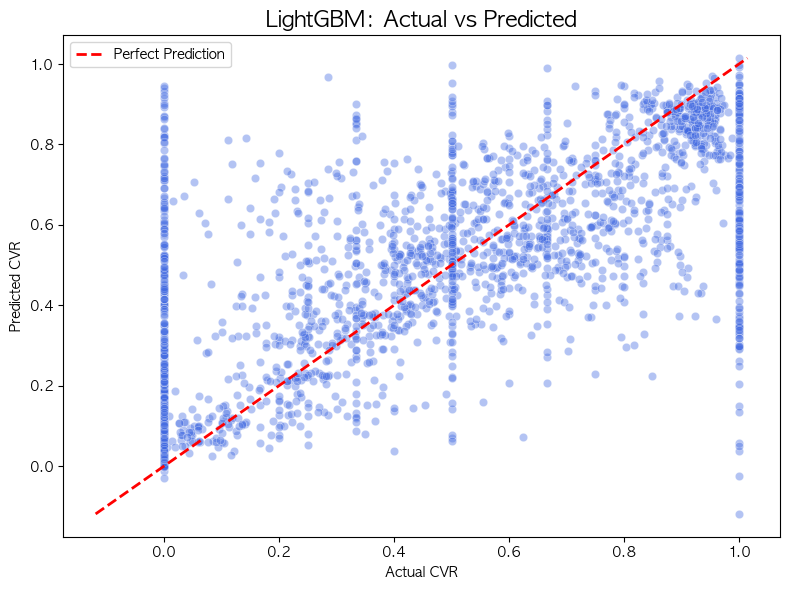

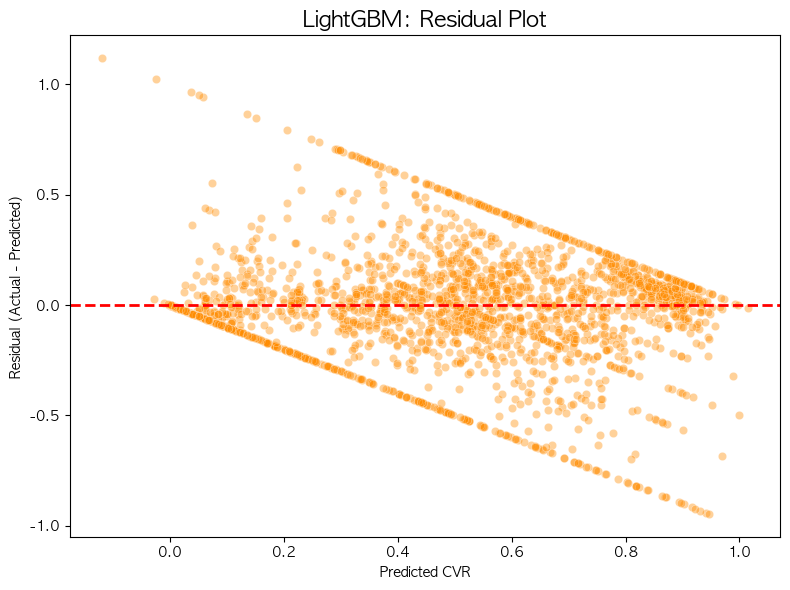

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ 예측
y_pred = lgbm_model.predict(X_test)

# ✅ 결과 DataFrame
results = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred,
    "Residual": y_test - y_pred
})

# --- ① Actual vs Predicted ---
plt.figure(figsize=(8,6))
sns.scatterplot(x="Actual", y="Predicted", data=results, alpha=0.4, color="royalblue")
min_val = min(results["Actual"].min(), results["Predicted"].min())
max_val = max(results["Actual"].max(), results["Predicted"].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label="Perfect Prediction")
plt.title("LightGBM: Actual vs Predicted", fontsize=16)
plt.xlabel("Actual CVR")
plt.ylabel("Predicted CVR")
plt.legend()
plt.tight_layout()
plt.show()

# --- ② Residual Plot (잔차 플롯) ---
plt.figure(figsize=(8,6))
sns.scatterplot(x="Predicted", y="Residual", data=results, alpha=0.4, color="darkorange")
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.title("LightGBM: Residual Plot", fontsize=16)
plt.xlabel("Predicted CVR")
plt.ylabel("Residual (Actual - Predicted)")
plt.tight_layout()
plt.show()

### 매체 순위 예측 모델링

In [44]:
import lightgbm as lgb
import optuna

/Users/t2024-m0247/Desktop/project5/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [45]:
# group_col 지정

group_col = 'domain_ads3step_os'

for df in [train_df, valid_df, test_df]:
    df["domain_ads3step_os"] = (
        df["domain"].astype(str) + "_" +
        df["ads_3step"].astype(str) + "_" +
        df["ads_os_type"].astype(str)
    )

In [46]:
# 정렬 
train_sorted = train_df.sort_values(group_col).reset_index(drop=True)
valid_sorted = valid_df.sort_values(group_col).reset_index(drop=True)
test_sorted  = test_df.sort_values(group_col).reset_index(drop=True)

# X, y 분리
X_train_sorted = train_sorted.drop(columns=['week_cvr','ads_idx', group_col])
y_train_sorted = train_sorted['week_cvr']

X_valid_sorted = valid_sorted.drop(columns=['week_cvr','ads_idx', group_col])
y_valid_sorted = valid_sorted['week_cvr']

X_test_sorted  = test_sorted.drop(columns=['week_cvr','ads_idx', group_col])
y_test_sorted  = test_sorted['week_cvr']

# 그룹별 size 계산 (group_col은 원본 정렬된 df에서 가져오기)
train_group_sizes = train_sorted.groupby(group_col).size().to_numpy()
valid_group_sizes = valid_sorted.groupby(group_col).size().to_numpy()
test_group_sizes  = test_sorted.groupby(group_col).size().to_numpy()

In [47]:
# 랭킹 성능 지표 함수

def evaluate_ranking_metrics(df, group_col, k_list=[1,3,5,10]):
    results = {}
    
    for group_id, group in df.groupby(group_col):
        y_true = group["true_cvr"].to_numpy()
        y_pred = group["pred_score"].to_numpy()

        # 정답 순서와 예측 순서
        true_order = np.argsort(-y_true)
        pred_order = np.argsort(-y_pred)

        # 각 그룹별 지표 저장
        for k in k_list:
            k_eff = min(k, len(y_true))  # 그룹 크기보다 k가 크면 조정
            if k_eff == 0:
                continue

            # Hit@K
            top_true = set(true_order[:k_eff])
            top_pred = set(pred_order[:k_eff])
            hit = len(top_true & top_pred) / k_eff
            results.setdefault(f"hit@{k}", []).append(hit)

            # NDCG@K
            y_true_sorted = y_true[pred_order[:k_eff]]
            gains = (2**y_true_sorted - 1) / np.log2(np.arange(2, k_eff+2))
            dcg = np.sum(gains)

            ideal_sorted = np.sort(y_true)[::-1][:k_eff]
            ideal_gains = (2**ideal_sorted - 1) / np.log2(np.arange(2, k_eff+2))
            idcg = np.sum(ideal_gains)

            ndcg = dcg / idcg if idcg > 0 else 0
            results.setdefault(f"ndcg@{k}", []).append(ndcg)

    # 그룹 평균 산출
    final_results = {metric: np.mean(vals) for metric, vals in results.items()}
    return final_results


In [48]:
# 파라미터 기본 모델로 n_bins 정하기

# n_bins개로 구간 나누어서 등급화
def binarize_labels(y, n_bins):
    # y를 0~1 범위로 정규화 후 n_bins 등급으로 매핑
    y_min, y_max = y.min(), y.max()
    if y_max == y_min:
        return np.zeros_like(y, dtype=int)  # 모두 같은 값일 경우 0으로
    y_scaled = (y - y_min) / (y_max - y_min)
    return np.floor(y_scaled * (n_bins - 1)).astype(int)

def run_ranker_with_bins(n_bins):
    # Train/Valid만 등급화
    y_train_rank = binarize_labels(y_train_sorted, n_bins)
    y_valid_rank = binarize_labels(y_valid_sorted, n_bins)

    ranker = lgb.LGBMRanker(
        objective="lambdarank",
        metric="ndcg",
        random_state=42,
        n_jobs=-1
    )

    ranker.fit(
        X_train_sorted,
        y_train_rank,
        group=train_group_sizes,
        eval_set=[(X_valid_sorted, y_valid_rank)],
        eval_group=[valid_group_sizes],
        eval_at=[5, 10],
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
    )

    # 📌 Test 예측 (테스트셋은 연속값 그대로 사용)
    preds = ranker.predict(X_test_sorted)

    test_result_df = test_sorted[[group_col]].copy()
    test_result_df["true_cvr"] = y_test_sorted.values
    test_result_df["pred_score"] = preds

    # 📊 랭킹 지표 계산
    metrics = evaluate_ranking_metrics(test_result_df, group_col=group_col)
    return metrics

# n_bins 후보 실험
bins_list = [10, 20, 30]
results = {}

for n in bins_list:
    print(f"\n🔎 n_bins={n} 실험 시작")
    metrics = run_ranker_with_bins(n)
    results[n] = metrics
    print(f"✅ n_bins={n} 결과:", metrics)

print("\n📊 최종 결과 비교")
for n, metrics in results.items():
    print(f"n_bins={n} → {metrics}")


🔎 n_bins=10 실험 시작
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's ndcg@5: 0.373427	valid_0's ndcg@10: 0.364265
✅ n_bins=10 결과: {'hit@1': 0.15384615384615385, 'ndcg@1': 0.5312754735606551, 'hit@3': 0.3333333333333333, 'ndcg@3': 0.5528687501929369, 'hit@5': 0.4153846153846154, 'ndcg@5': 0.6000518583408196, 'hit@10': 0.4538461538461539, 'ndcg@10': 0.5973619675829804}

🔎 n_bins=20 실험 시작
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	valid_0's ndcg@5: 0.389135	valid_0's ndcg@10: 0.354705
✅ n_bins=20 결과: {'hit@1': 0.15384615384615385, 'ndcg@1': 0.43796369922974515, 'hit@3': 0.23076923076923078, 'ndcg@3': 0.4064074630491977, 'hit@5': 0.3384615384615385, 'ndcg@5': 0.47234308084072235, 'hit@10': 0.4230769230769231, 'ndcg@10': 0.5136654489696599}

🔎 n_bins=30 실험 시작
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's ndcg@5

In [ ]:
# optuna로 파라미터 찾기

# 1) Label 이산화 (n_bins=10 고정)
def binarize_labels(y, n_bins=10):
    return np.floor(y * (n_bins - 1)).astype(int)

y_train_rank = binarize_labels(y_train_sorted, n_bins=10)
y_valid_rank = binarize_labels(y_valid_sorted, n_bins=10)
y_test_rank  = binarize_labels(y_test_sorted,  n_bins=10)


# 2) Optuna Objective 함수
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 700, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.08, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 70, 120),
        "max_depth": trial.suggest_int("max_depth", 5, 8),
        "min_child_samples": trial.suggest_int("min_child_samples", 40, 70),
        "subsample": trial.suggest_float("subsample", 0.8, 0.95),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.8, 0.95),
        "objective": "lambdarank",
        "metric": "ndcg",
        "random_state": 42,
        "n_jobs": -1
    }


    model = lgb.LGBMRanker(**params)

    model.fit(
        X_train_sorted, 
        y_train_rank,
        group=train_group_sizes,
        eval_set=[(X_valid_sorted, y_valid_rank)],
        eval_group=[valid_group_sizes],
        eval_at=[10],   # NDCG@10 기준으로 평가
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
    )

    preds = model.predict(X_valid_sorted)

    valid_result_df = valid_sorted[[group_col]].copy()
    valid_result_df["true_cvr"] = y_valid_sorted.values
    valid_result_df["pred_score"] = preds

    metrics = evaluate_ranking_metrics(valid_result_df, group_col, k_list=[10])
    return metrics["ndcg@10"] * -1  # Optuna는 최소화 → 음수로 변환


# 3) Optuna 실행
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200)

print("Best Trial:")
print(study.best_trial.params)

[I 2025-09-27 00:31:40,581] A new study created in memory with name: no-name-0642d5d7-93a9-461d-a7b1-3719a49f3094


Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:31:43,707] Trial 0 finished with value: -0.4843978580874406 and parameters: {'n_estimators': 949, 'learning_rate': 0.044185693297931955, 'num_leaves': 112, 'max_depth': 7, 'min_child_samples': 58, 'subsample': 0.8472970287644171, 'colsample_bytree': 0.917354943425508}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[170]	valid_0's ndcg@10: 0.426985
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:31:46,371] Trial 1 finished with value: -0.4198344693691001 and parameters: {'n_estimators': 729, 'learning_rate': 0.043003290405119035, 'num_leaves': 96, 'max_depth': 6, 'min_child_samples': 65, 'subsample': 0.8465038622768701, 'colsample_bytree': 0.9136135183113772}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[201]	valid_0's ndcg@10: 0.365252
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:31:47,568] Trial 2 finished with value: -0.42691259508052753 and parameters: {'n_estimators': 987, 'learning_rate': 0.07211633131737537, 'num_leaves': 105, 'max_depth': 6, 'min_child_samples': 63, 'subsample': 0.8497749456271597, 'colsample_bytree': 0.8656650207292279}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[20]	valid_0's ndcg@10: 0.366899
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:31:51,751] Trial 3 finished with value: -0.4079650772678826 and parameters: {'n_estimators': 758, 'learning_rate': 0.05562882129540819, 'num_leaves': 91, 'max_depth': 8, 'min_child_samples': 58, 'subsample': 0.8064868954880912, 'colsample_bytree': 0.821904492275162}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[139]	valid_0's ndcg@10: 0.332372
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:31:54,741] Trial 4 finished with value: -0.44094575402971764 and parameters: {'n_estimators': 951, 'learning_rate': 0.06495411377084177, 'num_leaves': 107, 'max_depth': 8, 'min_child_samples': 59, 'subsample': 0.9073860801016921, 'colsample_bytree': 0.9157028235861194}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[55]	valid_0's ndcg@10: 0.384906
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:31:55,828] Trial 5 finished with value: -0.37794358474434486 and parameters: {'n_estimators': 780, 'learning_rate': 0.033830019855886406, 'num_leaves': 72, 'max_depth': 6, 'min_child_samples': 44, 'subsample': 0.9418310429969361, 'colsample_bytree': 0.910570246420922}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[7]	valid_0's ndcg@10: 0.368776
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:31:58,076] Trial 6 finished with value: -0.42257076537151034 and parameters: {'n_estimators': 717, 'learning_rate': 0.05677045005184812, 'num_leaves': 116, 'max_depth': 8, 'min_child_samples': 54, 'subsample': 0.8987327038650904, 'colsample_bytree': 0.8754073451979654}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[29]	valid_0's ndcg@10: 0.36519
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:31:59,999] Trial 7 finished with value: -0.43825991158181743 and parameters: {'n_estimators': 749, 'learning_rate': 0.038211467300108264, 'num_leaves': 84, 'max_depth': 5, 'min_child_samples': 58, 'subsample': 0.9255142840303203, 'colsample_bytree': 0.8583051292470933}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[135]	valid_0's ndcg@10: 0.376891
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:32:01,551] Trial 8 finished with value: -0.42496560719072124 and parameters: {'n_estimators': 723, 'learning_rate': 0.03930927359208971, 'num_leaves': 98, 'max_depth': 5, 'min_child_samples': 66, 'subsample': 0.9010926765880525, 'colsample_bytree': 0.8526498047513813}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[62]	valid_0's ndcg@10: 0.388053
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:32:04,075] Trial 9 finished with value: -0.43514797096448987 and parameters: {'n_estimators': 900, 'learning_rate': 0.031315832532429165, 'num_leaves': 91, 'max_depth': 7, 'min_child_samples': 62, 'subsample': 0.857510013610035, 'colsample_bytree': 0.8297888640068201}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[116]	valid_0's ndcg@10: 0.365526
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:32:06,709] Trial 10 finished with value: -0.4496797118901166 and parameters: {'n_estimators': 843, 'learning_rate': 0.045767844788387836, 'num_leaves': 120, 'max_depth': 7, 'min_child_samples': 50, 'subsample': 0.8077007714824055, 'colsample_bytree': 0.938588198345898}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[116]	valid_0's ndcg@10: 0.386809
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:32:09,152] Trial 11 finished with value: -0.45169869372916444 and parameters: {'n_estimators': 841, 'learning_rate': 0.04797875071331655, 'num_leaves': 120, 'max_depth': 7, 'min_child_samples': 50, 'subsample': 0.80242392116092, 'colsample_bytree': 0.9465972130340625}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[107]	valid_0's ndcg@10: 0.380033
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:32:12,213] Trial 12 finished with value: -0.4362700979191328 and parameters: {'n_estimators': 840, 'learning_rate': 0.05162314132478451, 'num_leaves': 112, 'max_depth': 7, 'min_child_samples': 49, 'subsample': 0.8309018899471055, 'colsample_bytree': 0.9496829221246563}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[155]	valid_0's ndcg@10: 0.385817
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:32:16,231] Trial 13 finished with value: -0.426108534574669 and parameters: {'n_estimators': 902, 'learning_rate': 0.04769428566265122, 'num_leaves': 111, 'max_depth': 7, 'min_child_samples': 41, 'subsample': 0.8244585117077942, 'colsample_bytree': 0.8936473244066273}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[250]	valid_0's ndcg@10: 0.373658
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:32:17,536] Trial 14 finished with value: -0.4128232195437654 and parameters: {'n_estimators': 803, 'learning_rate': 0.040080091230937635, 'num_leaves': 118, 'max_depth': 7, 'min_child_samples': 70, 'subsample': 0.8720651800541648, 'colsample_bytree': 0.9280315021110519}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[6]	valid_0's ndcg@10: 0.367607
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:32:19,714] Trial 15 finished with value: -0.45397583475096964 and parameters: {'n_estimators': 896, 'learning_rate': 0.06340698124902198, 'num_leaves': 104, 'max_depth': 6, 'min_child_samples': 51, 'subsample': 0.8004189750552317, 'colsample_bytree': 0.8922562153826644}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[143]	valid_0's ndcg@10: 0.387534
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:32:22,943] Trial 16 finished with value: -0.4209290400478271 and parameters: {'n_estimators': 905, 'learning_rate': 0.07742386853588024, 'num_leaves': 102, 'max_depth': 6, 'min_child_samples': 54, 'subsample': 0.8325080433469572, 'colsample_bytree': 0.8961109191738151}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[276]	valid_0's ndcg@10: 0.370016
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:32:23,924] Trial 17 finished with value: -0.42347235332504063 and parameters: {'n_estimators': 947, 'learning_rate': 0.06544248666908409, 'num_leaves': 110, 'max_depth': 5, 'min_child_samples': 44, 'subsample': 0.8730043088450747, 'colsample_bytree': 0.889503599758096}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[32]	valid_0's ndcg@10: 0.370515
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:32:27,644] Trial 18 finished with value: -0.43815797352662994 and parameters: {'n_estimators': 994, 'learning_rate': 0.0606255639485006, 'num_leaves': 101, 'max_depth': 6, 'min_child_samples': 52, 'subsample': 0.822974669739117, 'colsample_bytree': 0.8446607667822181}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[336]	valid_0's ndcg@10: 0.389666
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:32:30,066] Trial 19 finished with value: -0.44621214564409045 and parameters: {'n_estimators': 878, 'learning_rate': 0.05267180571115344, 'num_leaves': 85, 'max_depth': 6, 'min_child_samples': 47, 'subsample': 0.8865667404134998, 'colsample_bytree': 0.8015553483327452}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[174]	valid_0's ndcg@10: 0.381384
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:32:31,576] Trial 20 finished with value: -0.4210645838659224 and parameters: {'n_estimators': 938, 'learning_rate': 0.03542189114932955, 'num_leaves': 105, 'max_depth': 5, 'min_child_samples': 56, 'subsample': 0.8523441436360077, 'colsample_bytree': 0.882794170251688}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[103]	valid_0's ndcg@10: 0.367219
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:32:34,559] Trial 21 finished with value: -0.46441434303213397 and parameters: {'n_estimators': 864, 'learning_rate': 0.04393845883103369, 'num_leaves': 115, 'max_depth': 7, 'min_child_samples': 51, 'subsample': 0.8025693182457765, 'colsample_bytree': 0.9300407675641736}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[142]	valid_0's ndcg@10: 0.388701
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:32:37,677] Trial 22 finished with value: -0.44116787974693616 and parameters: {'n_estimators': 869, 'learning_rate': 0.04195265550604022, 'num_leaves': 114, 'max_depth': 7, 'min_child_samples': 46, 'subsample': 0.8182802036780648, 'colsample_bytree': 0.9283880519680391}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[164]	valid_0's ndcg@10: 0.376259
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:32:40,205] Trial 23 finished with value: -0.4221855448098374 and parameters: {'n_estimators': 927, 'learning_rate': 0.04497853886350453, 'num_leaves': 107, 'max_depth': 8, 'min_child_samples': 55, 'subsample': 0.8005381041356088, 'colsample_bytree': 0.901177995562906}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[72]	valid_0's ndcg@10: 0.363984
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:32:42,735] Trial 24 finished with value: -0.44101282556486854 and parameters: {'n_estimators': 969, 'learning_rate': 0.05090252980013519, 'num_leaves': 114, 'max_depth': 7, 'min_child_samples': 52, 'subsample': 0.8389211094959271, 'colsample_bytree': 0.9308725102654716}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[112]	valid_0's ndcg@10: 0.369044
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:32:45,110] Trial 25 finished with value: -0.45907304823748896 and parameters: {'n_estimators': 813, 'learning_rate': 0.05975675846160626, 'num_leaves': 108, 'max_depth': 6, 'min_child_samples': 60, 'subsample': 0.8637769960488177, 'colsample_bytree': 0.9084663037485281}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[178]	valid_0's ndcg@10: 0.393564
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:32:46,742] Trial 26 finished with value: -0.4341083224543952 and parameters: {'n_estimators': 811, 'learning_rate': 0.056773891914908295, 'num_leaves': 109, 'max_depth': 7, 'min_child_samples': 61, 'subsample': 0.8637124938301018, 'colsample_bytree': 0.9170511180718982}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[43]	valid_0's ndcg@10: 0.408475
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:32:48,525] Trial 27 finished with value: -0.4288859497977763 and parameters: {'n_estimators': 810, 'learning_rate': 0.03625458928113441, 'num_leaves': 116, 'max_depth': 8, 'min_child_samples': 60, 'subsample': 0.878807894184635, 'colsample_bytree': 0.9024298011051707}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[23]	valid_0's ndcg@10: 0.388866
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:32:51,050] Trial 28 finished with value: -0.4443705429810802 and parameters: {'n_estimators': 794, 'learning_rate': 0.07004756191572353, 'num_leaves': 99, 'max_depth': 6, 'min_child_samples': 57, 'subsample': 0.8878581944759052, 'colsample_bytree': 0.9235637909777242}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[186]	valid_0's ndcg@10: 0.380712
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:32:54,169] Trial 29 finished with value: -0.4606131986006433 and parameters: {'n_estimators': 700, 'learning_rate': 0.043455951941036644, 'num_leaves': 93, 'max_depth': 7, 'min_child_samples': 66, 'subsample': 0.842147335349563, 'colsample_bytree': 0.9094125122379273}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[181]	valid_0's ndcg@10: 0.400441
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:32:58,299] Trial 30 finished with value: -0.4305028348199789 and parameters: {'n_estimators': 704, 'learning_rate': 0.043558835644310526, 'num_leaves': 94, 'max_depth': 7, 'min_child_samples': 67, 'subsample': 0.8436224292429332, 'colsample_bytree': 0.939755196262993}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[290]	valid_0's ndcg@10: 0.381362
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:33:00,234] Trial 31 finished with value: -0.4612352521207621 and parameters: {'n_estimators': 758, 'learning_rate': 0.042436991844975236, 'num_leaves': 95, 'max_depth': 7, 'min_child_samples': 64, 'subsample': 0.8649069939858336, 'colsample_bytree': 0.9083383475128652}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[77]	valid_0's ndcg@10: 0.399143
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:33:02,170] Trial 32 finished with value: -0.4252375001793103 and parameters: {'n_estimators': 755, 'learning_rate': 0.041958977044037636, 'num_leaves': 85, 'max_depth': 7, 'min_child_samples': 64, 'subsample': 0.8145745732027517, 'colsample_bytree': 0.9179271131024935}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[76]	valid_0's ndcg@10: 0.377105
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:33:04,861] Trial 33 finished with value: -0.45116493622372933 and parameters: {'n_estimators': 778, 'learning_rate': 0.04659151346971911, 'num_leaves': 93, 'max_depth': 8, 'min_child_samples': 70, 'subsample': 0.8425285793090218, 'colsample_bytree': 0.9350598685604686}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[91]	valid_0's ndcg@10: 0.399399
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:33:06,722] Trial 34 finished with value: -0.4170345442549734 and parameters: {'n_estimators': 741, 'learning_rate': 0.041082170966869294, 'num_leaves': 80, 'max_depth': 7, 'min_child_samples': 68, 'subsample': 0.8566395055362325, 'colsample_bytree': 0.905347428631087}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[71]	valid_0's ndcg@10: 0.354095
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:33:08,312] Trial 35 finished with value: -0.4570064603921071 and parameters: {'n_estimators': 775, 'learning_rate': 0.037267707261239354, 'num_leaves': 97, 'max_depth': 8, 'min_child_samples': 64, 'subsample': 0.8349673223964407, 'colsample_bytree': 0.9202471966842103}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[10]	valid_0's ndcg@10: 0.394726
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:33:09,552] Trial 36 finished with value: -0.41459058025538814 and parameters: {'n_estimators': 700, 'learning_rate': 0.043854199718667615, 'num_leaves': 87, 'max_depth': 7, 'min_child_samples': 63, 'subsample': 0.8485167989317127, 'colsample_bytree': 0.8731061364731538}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[6]	valid_0's ndcg@10: 0.390129
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:33:12,555] Trial 37 finished with value: -0.4338666544467579 and parameters: {'n_estimators': 734, 'learning_rate': 0.03270028359336284, 'num_leaves': 79, 'max_depth': 8, 'min_child_samples': 68, 'subsample': 0.864935444984023, 'colsample_bytree': 0.9120360479336728}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[118]	valid_0's ndcg@10: 0.365912
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:33:15,159] Trial 38 finished with value: -0.46313475192542847 and parameters: {'n_estimators': 966, 'learning_rate': 0.049269856313160686, 'num_leaves': 89, 'max_depth': 7, 'min_child_samples': 65, 'subsample': 0.9126234393287674, 'colsample_bytree': 0.8857481348975296}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[132]	valid_0's ndcg@10: 0.403246
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:33:16,844] Trial 39 finished with value: -0.4396884127857186 and parameters: {'n_estimators': 976, 'learning_rate': 0.0498773323238652, 'num_leaves': 89, 'max_depth': 7, 'min_child_samples': 62, 'subsample': 0.9190623924404551, 'colsample_bytree': 0.8800145573739817}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[47]	valid_0's ndcg@10: 0.385627
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:33:19,261] Trial 40 finished with value: -0.42855326274730327 and parameters: {'n_estimators': 919, 'learning_rate': 0.05316594864128403, 'num_leaves': 80, 'max_depth': 7, 'min_child_samples': 58, 'subsample': 0.9403985711121399, 'colsample_bytree': 0.8672704800909605}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[114]	valid_0's ndcg@10: 0.36614
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:33:20,710] Trial 41 finished with value: -0.43297598323887865 and parameters: {'n_estimators': 866, 'learning_rate': 0.044578296961613036, 'num_leaves': 91, 'max_depth': 7, 'min_child_samples': 66, 'subsample': 0.9148090500514668, 'colsample_bytree': 0.8867453324127903}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[26]	valid_0's ndcg@10: 0.389951
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:33:21,997] Trial 42 finished with value: -0.43611115631646497 and parameters: {'n_estimators': 962, 'learning_rate': 0.03945931164864842, 'num_leaves': 94, 'max_depth': 7, 'min_child_samples': 64, 'subsample': 0.9303417202616723, 'colsample_bytree': 0.8987278629526311}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[8]	valid_0's ndcg@10: 0.4209
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:33:23,874] Trial 43 finished with value: -0.4525484910096225 and parameters: {'n_estimators': 986, 'learning_rate': 0.04907592176696218, 'num_leaves': 96, 'max_depth': 7, 'min_child_samples': 65, 'subsample': 0.8927227178818509, 'colsample_bytree': 0.9112598676987184}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[67]	valid_0's ndcg@10: 0.383297
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:33:27,985] Trial 44 finished with value: -0.4521004614947086 and parameters: {'n_estimators': 829, 'learning_rate': 0.04598389257091755, 'num_leaves': 89, 'max_depth': 7, 'min_child_samples': 67, 'subsample': 0.8801211563441877, 'colsample_bytree': 0.941755746742166}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[279]	valid_0's ndcg@10: 0.402014
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:33:30,580] Trial 45 finished with value: -0.4403693456458216 and parameters: {'n_estimators': 765, 'learning_rate': 0.03868173260262268, 'num_leaves': 101, 'max_depth': 8, 'min_child_samples': 59, 'subsample': 0.901369887920819, 'colsample_bytree': 0.9251596926033346}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[76]	valid_0's ndcg@10: 0.39894
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:33:33,329] Trial 46 finished with value: -0.43718763470406663 and parameters: {'n_estimators': 716, 'learning_rate': 0.04160603323385117, 'num_leaves': 72, 'max_depth': 7, 'min_child_samples': 62, 'subsample': 0.8096280596728488, 'colsample_bytree': 0.9058750607953707}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[145]	valid_0's ndcg@10: 0.370091
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:33:36,177] Trial 47 finished with value: -0.441822300102003 and parameters: {'n_estimators': 955, 'learning_rate': 0.048136124952760914, 'num_leaves': 92, 'max_depth': 7, 'min_child_samples': 69, 'subsample': 0.8283573426319145, 'colsample_bytree': 0.9335667615495198}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[159]	valid_0's ndcg@10: 0.380406
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:33:37,242] Trial 48 finished with value: -0.37541229845088264 and parameters: {'n_estimators': 933, 'learning_rate': 0.046671464021473846, 'num_leaves': 82, 'max_depth': 6, 'min_child_samples': 66, 'subsample': 0.8555201358225923, 'colsample_bytree': 0.9137803322853282}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[10]	valid_0's ndcg@10: 0.33995
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:33:38,914] Trial 49 finished with value: -0.4431104340080451 and parameters: {'n_estimators': 856, 'learning_rate': 0.05387841922431046, 'num_leaves': 77, 'max_depth': 7, 'min_child_samples': 65, 'subsample': 0.869578426697755, 'colsample_bytree': 0.9219533650049329}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[50]	valid_0's ndcg@10: 0.39096
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:33:41,144] Trial 50 finished with value: -0.4447847549529142 and parameters: {'n_estimators': 883, 'learning_rate': 0.0346865816146835, 'num_leaves': 99, 'max_depth': 7, 'min_child_samples': 54, 'subsample': 0.8491343358405209, 'colsample_bytree': 0.860234614516762}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[91]	valid_0's ndcg@10: 0.390567
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:33:42,143] Trial 51 finished with value: -0.42317812684670586 and parameters: {'n_estimators': 823, 'learning_rate': 0.05914173721990473, 'num_leaves': 113, 'max_depth': 6, 'min_child_samples': 61, 'subsample': 0.8604888502677008, 'colsample_bytree': 0.9071186356266884}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[7]	valid_0's ndcg@10: 0.375707
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:33:45,053] Trial 52 finished with value: -0.44938366568104393 and parameters: {'n_estimators': 797, 'learning_rate': 0.043619224330028954, 'num_leaves': 117, 'max_depth': 6, 'min_child_samples': 60, 'subsample': 0.9479676868609552, 'colsample_bytree': 0.8959112835114532}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[234]	valid_0's ndcg@10: 0.384415
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:33:47,809] Trial 53 finished with value: -0.4453335941362795 and parameters: {'n_estimators': 746, 'learning_rate': 0.06806694503751842, 'num_leaves': 108, 'max_depth': 6, 'min_child_samples': 57, 'subsample': 0.867427636689683, 'colsample_bytree': 0.886469031740226}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[210]	valid_0's ndcg@10: 0.386518
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:33:49,146] Trial 54 finished with value: -0.43289819262694795 and parameters: {'n_estimators': 767, 'learning_rate': 0.03769791945276555, 'num_leaves': 119, 'max_depth': 7, 'min_child_samples': 59, 'subsample': 0.8799384050783429, 'colsample_bytree': 0.9094389669727723}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[13]	valid_0's ndcg@10: 0.378202
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:33:52,462] Trial 55 finished with value: -0.4647717200444437 and parameters: {'n_estimators': 787, 'learning_rate': 0.0793977830587118, 'num_leaves': 103, 'max_depth': 6, 'min_child_samples': 63, 'subsample': 0.8415718768841164, 'colsample_bytree': 0.9156630084997601}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[292]	valid_0's ndcg@10: 0.391527
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:33:53,815] Trial 56 finished with value: -0.4344850936370916 and parameters: {'n_estimators': 917, 'learning_rate': 0.07633304722381798, 'num_leaves': 102, 'max_depth': 6, 'min_child_samples': 48, 'subsample': 0.837465176141364, 'colsample_bytree': 0.9435447163177408}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[45]	valid_0's ndcg@10: 0.378833
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:33:55,974] Trial 57 finished with value: -0.4225203609210093 and parameters: {'n_estimators': 718, 'learning_rate': 0.040291510936809175, 'num_leaves': 89, 'max_depth': 5, 'min_child_samples': 63, 'subsample': 0.8288348954164172, 'colsample_bytree': 0.8451941899265436}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[198]	valid_0's ndcg@10: 0.373291
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:34:01,112] Trial 58 finished with value: -0.46083556149175103 and parameters: {'n_estimators': 999, 'learning_rate': 0.030936018568765232, 'num_leaves': 96, 'max_depth': 7, 'min_child_samples': 52, 'subsample': 0.8431951477603535, 'colsample_bytree': 0.9280431613147319}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[334]	valid_0's ndcg@10: 0.408456
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:34:05,344] Trial 59 finished with value: -0.4501303044567627 and parameters: {'n_estimators': 992, 'learning_rate': 0.03022745252666995, 'num_leaves': 104, 'max_depth': 7, 'min_child_samples': 49, 'subsample': 0.8224902039768337, 'colsample_bytree': 0.9482187353688036}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[267]	valid_0's ndcg@10: 0.379765
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:34:08,582] Trial 60 finished with value: -0.45376235759872047 and parameters: {'n_estimators': 982, 'learning_rate': 0.033041162400007394, 'num_leaves': 111, 'max_depth': 7, 'min_child_samples': 52, 'subsample': 0.8526425646574075, 'colsample_bytree': 0.9279887238456606}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[182]	valid_0's ndcg@10: 0.396823
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:34:11,794] Trial 61 finished with value: -0.44924079247553456 and parameters: {'n_estimators': 944, 'learning_rate': 0.055227184682003695, 'num_leaves': 97, 'max_depth': 7, 'min_child_samples': 50, 'subsample': 0.8391415713167292, 'colsample_bytree': 0.935326019568584}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[180]	valid_0's ndcg@10: 0.38005
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:34:13,228] Trial 62 finished with value: -0.42242248650023906 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07918585402481983, 'num_leaves': 95, 'max_depth': 7, 'min_child_samples': 53, 'subsample': 0.8456565080940747, 'colsample_bytree': 0.9170423587067942}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[21]	valid_0's ndcg@10: 0.363895
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:34:18,091] Trial 63 finished with value: -0.44409871743299495 and parameters: {'n_estimators': 956, 'learning_rate': 0.04263084365836477, 'num_leaves': 105, 'max_depth': 7, 'min_child_samples': 55, 'subsample': 0.8595570143750231, 'colsample_bytree': 0.9277303807920053}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[339]	valid_0's ndcg@10: 0.383777
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:34:20,296] Trial 64 finished with value: -0.4391212871872561 and parameters: {'n_estimators': 971, 'learning_rate': 0.03619816945075134, 'num_leaves': 91, 'max_depth': 7, 'min_child_samples': 51, 'subsample': 0.8121762197870201, 'colsample_bytree': 0.9213530721565868}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[91]	valid_0's ndcg@10: 0.407904
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:34:22,920] Trial 65 finished with value: -0.4428722249600005 and parameters: {'n_estimators': 890, 'learning_rate': 0.050938353444525575, 'num_leaves': 87, 'max_depth': 7, 'min_child_samples': 67, 'subsample': 0.8754466076430261, 'colsample_bytree': 0.8923417916712194}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[142]	valid_0's ndcg@10: 0.377697
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:34:26,314] Trial 66 finished with value: -0.4246551686737576 and parameters: {'n_estimators': 789, 'learning_rate': 0.03167584270792548, 'num_leaves': 99, 'max_depth': 6, 'min_child_samples': 63, 'subsample': 0.8166530959945145, 'colsample_bytree': 0.8995749005277298}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[299]	valid_0's ndcg@10: 0.365069
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:34:28,996] Trial 67 finished with value: -0.4504296282783294 and parameters: {'n_estimators': 732, 'learning_rate': 0.06270266824883228, 'num_leaves': 114, 'max_depth': 7, 'min_child_samples': 45, 'subsample': 0.8421556123707092, 'colsample_bytree': 0.9149325457038874}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[127]	valid_0's ndcg@10: 0.393883
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:34:32,396] Trial 68 finished with value: -0.4415128072960657 and parameters: {'n_estimators': 833, 'learning_rate': 0.07368650475345788, 'num_leaves': 93, 'max_depth': 8, 'min_child_samples': 40, 'subsample': 0.8324179986891479, 'colsample_bytree': 0.932519843124375}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[134]	valid_0's ndcg@10: 0.386467
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:34:37,708] Trial 69 finished with value: -0.44775427631971554 and parameters: {'n_estimators': 847, 'learning_rate': 0.045230915568692354, 'num_leaves': 87, 'max_depth': 7, 'min_child_samples': 56, 'subsample': 0.8514736879960214, 'colsample_bytree': 0.9030617632871597}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[207]	valid_0's ndcg@10: 0.387975
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:34:39,646] Trial 70 finished with value: -0.43136903714907504 and parameters: {'n_estimators': 999, 'learning_rate': 0.047328882652419954, 'num_leaves': 96, 'max_depth': 6, 'min_child_samples': 65, 'subsample': 0.8253816667909827, 'colsample_bytree': 0.8252469627149279}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[110]	valid_0's ndcg@10: 0.376564
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:34:41,066] Trial 71 finished with value: -0.39194983422179364 and parameters: {'n_estimators': 812, 'learning_rate': 0.041000588930585176, 'num_leaves': 109, 'max_depth': 6, 'min_child_samples': 61, 'subsample': 0.8632729482644256, 'colsample_bytree': 0.9087813173010438}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[58]	valid_0's ndcg@10: 0.342222
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:34:42,068] Trial 72 finished with value: -0.4203632629959015 and parameters: {'n_estimators': 761, 'learning_rate': 0.06629091866503309, 'num_leaves': 106, 'max_depth': 6, 'min_child_samples': 62, 'subsample': 0.8474399839969651, 'colsample_bytree': 0.9198687116710468}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[6]	valid_0's ndcg@10: 0.385109
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:34:44,343] Trial 73 finished with value: -0.4216119700131424 and parameters: {'n_estimators': 821, 'learning_rate': 0.06011048020565702, 'num_leaves': 115, 'max_depth': 7, 'min_child_samples': 60, 'subsample': 0.8054479599793904, 'colsample_bytree': 0.9244167210748664}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[104]	valid_0's ndcg@10: 0.343773
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:34:46,821] Trial 74 finished with value: -0.4359395231897857 and parameters: {'n_estimators': 775, 'learning_rate': 0.057456723041808974, 'num_leaves': 110, 'max_depth': 6, 'min_child_samples': 64, 'subsample': 0.8750910717434244, 'colsample_bytree': 0.9369518552915543}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[186]	valid_0's ndcg@10: 0.383692
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:34:48,939] Trial 75 finished with value: -0.4373352168689682 and parameters: {'n_estimators': 791, 'learning_rate': 0.049329582475537904, 'num_leaves': 107, 'max_depth': 7, 'min_child_samples': 53, 'subsample': 0.8562816315058358, 'colsample_bytree': 0.8118629719627448}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[77]	valid_0's ndcg@10: 0.392998
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:34:49,785] Trial 76 finished with value: -0.4075218847685054 and parameters: {'n_estimators': 964, 'learning_rate': 0.042818413870940306, 'num_leaves': 102, 'max_depth': 5, 'min_child_samples': 58, 'subsample': 0.8858122922833246, 'colsample_bytree': 0.9147793116305721}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[12]	valid_0's ndcg@10: 0.378415
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:34:55,049] Trial 77 finished with value: -0.4325472614414315 and parameters: {'n_estimators': 782, 'learning_rate': 0.04479917659197816, 'num_leaves': 111, 'max_depth': 7, 'min_child_samples': 57, 'subsample': 0.8362352352199204, 'colsample_bytree': 0.9295492781245398}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[384]	valid_0's ndcg@10: 0.377832
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:34:58,017] Trial 78 finished with value: -0.4422988815075198 and parameters: {'n_estimators': 803, 'learning_rate': 0.07110841201642848, 'num_leaves': 116, 'max_depth': 6, 'min_child_samples': 66, 'subsample': 0.8410317119903535, 'colsample_bytree': 0.8808192256011184}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[252]	valid_0's ndcg@10: 0.388104
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:34:59,778] Trial 79 finished with value: -0.43088455115499386 and parameters: {'n_estimators': 707, 'learning_rate': 0.06257907573066523, 'num_leaves': 100, 'max_depth': 7, 'min_child_samples': 68, 'subsample': 0.8699730948048732, 'colsample_bytree': 0.9047211112142901}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[55]	valid_0's ndcg@10: 0.364845
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:35:00,748] Trial 80 finished with value: -0.4504947788574788 and parameters: {'n_estimators': 753, 'learning_rate': 0.051930458590562736, 'num_leaves': 112, 'max_depth': 6, 'min_child_samples': 56, 'subsample': 0.9045719839860461, 'colsample_bytree': 0.8755381305730832}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[10]	valid_0's ndcg@10: 0.408088
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:35:02,366] Trial 81 finished with value: -0.43316661805708734 and parameters: {'n_estimators': 771, 'learning_rate': 0.03791110390192607, 'num_leaves': 98, 'max_depth': 8, 'min_child_samples': 64, 'subsample': 0.8532597497246086, 'colsample_bytree': 0.9193686682935077}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[3]	valid_0's ndcg@10: 0.348233
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:35:07,732] Trial 82 finished with value: -0.4479039011054214 and parameters: {'n_estimators': 744, 'learning_rate': 0.0395782469876337, 'num_leaves': 94, 'max_depth': 8, 'min_child_samples': 65, 'subsample': 0.8343760637998991, 'colsample_bytree': 0.9252436240603297}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[270]	valid_0's ndcg@10: 0.403456
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:35:09,220] Trial 83 finished with value: -0.42128217015447195 and parameters: {'n_estimators': 980, 'learning_rate': 0.034777902767660795, 'num_leaves': 90, 'max_depth': 8, 'min_child_samples': 63, 'subsample': 0.8445265902570998, 'colsample_bytree': 0.9118563199875996}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[4]	valid_0's ndcg@10: 0.357263
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:35:11,121] Trial 84 finished with value: -0.40707489460180196 and parameters: {'n_estimators': 785, 'learning_rate': 0.03663912937561233, 'num_leaves': 97, 'max_depth': 8, 'min_child_samples': 62, 'subsample': 0.8203848917086682, 'colsample_bytree': 0.896321852738942}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[30]	valid_0's ndcg@10: 0.370879
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:35:13,273] Trial 85 finished with value: -0.44500949338639517 and parameters: {'n_estimators': 801, 'learning_rate': 0.042416371327291015, 'num_leaves': 92, 'max_depth': 7, 'min_child_samples': 51, 'subsample': 0.8610608889251544, 'colsample_bytree': 0.9179750331406231}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[85]	valid_0's ndcg@10: 0.405221
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:35:14,305] Trial 86 finished with value: -0.4196677367764648 and parameters: {'n_estimators': 864, 'learning_rate': 0.04397048044304214, 'num_leaves': 103, 'max_depth': 5, 'min_child_samples': 65, 'subsample': 0.8300347992919779, 'colsample_bytree': 0.9083951645711118}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[39]	valid_0's ndcg@10: 0.362016
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:35:17,028] Trial 87 finished with value: -0.4548362344060426 and parameters: {'n_estimators': 725, 'learning_rate': 0.04093575355688513, 'num_leaves': 93, 'max_depth': 7, 'min_child_samples': 60, 'subsample': 0.8486389449124521, 'colsample_bytree': 0.9230265807648803}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[153]	valid_0's ndcg@10: 0.39194
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:35:19,615] Trial 88 finished with value: -0.4453949537868163 and parameters: {'n_estimators': 819, 'learning_rate': 0.03712604266838164, 'num_leaves': 95, 'max_depth': 8, 'min_child_samples': 59, 'subsample': 0.9335335926054126, 'colsample_bytree': 0.9122432952093047}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[94]	valid_0's ndcg@10: 0.367732
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:35:20,805] Trial 89 finished with value: -0.43559699828519965 and parameters: {'n_estimators': 911, 'learning_rate': 0.04670382637020053, 'num_leaves': 97, 'max_depth': 7, 'min_child_samples': 67, 'subsample': 0.8932611286524361, 'colsample_bytree': 0.8880609773462352}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[8]	valid_0's ndcg@10: 0.374192
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:35:22,764] Trial 90 finished with value: -0.45349827524335884 and parameters: {'n_estimators': 939, 'learning_rate': 0.0332796972570548, 'num_leaves': 100, 'max_depth': 6, 'min_child_samples': 69, 'subsample': 0.8577045110308221, 'colsample_bytree': 0.9388938299973486}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[128]	valid_0's ndcg@10: 0.38803
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:35:26,052] Trial 91 finished with value: -0.43840867477900897 and parameters: {'n_estimators': 723, 'learning_rate': 0.04040495673489601, 'num_leaves': 93, 'max_depth': 7, 'min_child_samples': 61, 'subsample': 0.8481365033305349, 'colsample_bytree': 0.9229406887216055}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[193]	valid_0's ndcg@10: 0.381732
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:35:28,082] Trial 92 finished with value: -0.4504445464938281 and parameters: {'n_estimators': 759, 'learning_rate': 0.041394130277667765, 'num_leaves': 90, 'max_depth': 7, 'min_child_samples': 60, 'subsample': 0.8647372546602927, 'colsample_bytree': 0.929889767259112}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[72]	valid_0's ndcg@10: 0.398422
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:35:31,596] Trial 93 finished with value: -0.4513441035090913 and parameters: {'n_estimators': 709, 'learning_rate': 0.03834187382857803, 'num_leaves': 95, 'max_depth': 7, 'min_child_samples': 63, 'subsample': 0.9115919050660959, 'colsample_bytree': 0.9157043572892317}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[207]	valid_0's ndcg@10: 0.388457
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:35:35,744] Trial 94 finished with value: -0.43889158432912717 and parameters: {'n_estimators': 734, 'learning_rate': 0.04560819571091338, 'num_leaves': 92, 'max_depth': 7, 'min_child_samples': 64, 'subsample': 0.8400141345868896, 'colsample_bytree': 0.9316486906905895}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[255]	valid_0's ndcg@10: 0.374924
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:35:37,404] Trial 95 finished with value: -0.4386500794309555 and parameters: {'n_estimators': 718, 'learning_rate': 0.04810213725869136, 'num_leaves': 118, 'max_depth': 7, 'min_child_samples': 66, 'subsample': 0.8266318047248234, 'colsample_bytree': 0.9250118137682207}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[37]	valid_0's ndcg@10: 0.395187
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:35:38,897] Trial 96 finished with value: -0.43935632319423107 and parameters: {'n_estimators': 727, 'learning_rate': 0.03015606075689886, 'num_leaves': 86, 'max_depth': 7, 'min_child_samples': 55, 'subsample': 0.8451010433520164, 'colsample_bytree': 0.9018253192900043}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[25]	valid_0's ndcg@10: 0.411235
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:35:41,899] Trial 97 finished with value: -0.42889250366105264 and parameters: {'n_estimators': 712, 'learning_rate': 0.03933053638035754, 'num_leaves': 98, 'max_depth': 7, 'min_child_samples': 49, 'subsample': 0.8507661113325453, 'colsample_bytree': 0.9418962216872395}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[144]	valid_0's ndcg@10: 0.374069
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:35:45,386] Trial 98 finished with value: -0.47532448167092806 and parameters: {'n_estimators': 751, 'learning_rate': 0.04404811807880203, 'num_leaves': 88, 'max_depth': 7, 'min_child_samples': 62, 'subsample': 0.8358333200045408, 'colsample_bytree': 0.9201188495856428}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[203]	valid_0's ndcg@10: 0.430738
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:35:47,628] Trial 99 finished with value: -0.44248586172055643 and parameters: {'n_estimators': 740, 'learning_rate': 0.03196193413388416, 'num_leaves': 84, 'max_depth': 7, 'min_child_samples': 62, 'subsample': 0.8355408901982175, 'colsample_bytree': 0.905848513199101}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[89]	valid_0's ndcg@10: 0.381407
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:35:49,499] Trial 100 finished with value: -0.4299210494490822 and parameters: {'n_estimators': 776, 'learning_rate': 0.05027516544938103, 'num_leaves': 88, 'max_depth': 6, 'min_child_samples': 64, 'subsample': 0.8315793396243335, 'colsample_bytree': 0.919293385662105}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[96]	valid_0's ndcg@10: 0.366899
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:35:52,234] Trial 101 finished with value: -0.4143958655522575 and parameters: {'n_estimators': 752, 'learning_rate': 0.04373920554407384, 'num_leaves': 113, 'max_depth': 7, 'min_child_samples': 59, 'subsample': 0.8426436011476189, 'colsample_bytree': 0.926630494750941}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[130]	valid_0's ndcg@10: 0.35308
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:35:55,641] Trial 102 finished with value: -0.4386721746974976 and parameters: {'n_estimators': 767, 'learning_rate': 0.042035388005612795, 'num_leaves': 90, 'max_depth': 7, 'min_child_samples': 61, 'subsample': 0.8550848628912724, 'colsample_bytree': 0.9103952188337157}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[177]	valid_0's ndcg@10: 0.383023
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:35:58,700] Trial 103 finished with value: -0.4532852548649887 and parameters: {'n_estimators': 972, 'learning_rate': 0.044400757918052695, 'num_leaves': 93, 'max_depth': 7, 'min_child_samples': 63, 'subsample': 0.8382777568207732, 'colsample_bytree': 0.9219127199657129}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[147]	valid_0's ndcg@10: 0.404235
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:36:02,097] Trial 104 finished with value: -0.44040958766965227 and parameters: {'n_estimators': 701, 'learning_rate': 0.040673003250413675, 'num_leaves': 88, 'max_depth': 7, 'min_child_samples': 60, 'subsample': 0.8491246100792542, 'colsample_bytree': 0.9146737923020526}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[179]	valid_0's ndcg@10: 0.379284
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:36:04,555] Trial 105 finished with value: -0.45844841298999545 and parameters: {'n_estimators': 739, 'learning_rate': 0.046403742332490755, 'num_leaves': 96, 'max_depth': 7, 'min_child_samples': 53, 'subsample': 0.8828620522154802, 'colsample_bytree': 0.9448775555425758}. Best is trial 0 with value: -0.4843978580874406.


Early stopping, best iteration is:
[93]	valid_0's ndcg@10: 0.364913
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:36:07,595] Trial 106 finished with value: -0.4856268619020559 and parameters: {'n_estimators': 749, 'learning_rate': 0.04660301139915901, 'num_leaves': 108, 'max_depth': 7, 'min_child_samples': 53, 'subsample': 0.9237143415502541, 'colsample_bytree': 0.9465274883685337}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[130]	valid_0's ndcg@10: 0.399232
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:36:11,335] Trial 107 finished with value: -0.45951033581320255 and parameters: {'n_estimators': 740, 'learning_rate': 0.04613241145578421, 'num_leaves': 108, 'max_depth': 7, 'min_child_samples': 53, 'subsample': 0.9096464062337162, 'colsample_bytree': 0.9447048026425444}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[178]	valid_0's ndcg@10: 0.39778
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:36:14,516] Trial 108 finished with value: -0.44390988327704284 and parameters: {'n_estimators': 747, 'learning_rate': 0.04846278364044402, 'num_leaves': 108, 'max_depth': 7, 'min_child_samples': 51, 'subsample': 0.919119361953495, 'colsample_bytree': 0.9486524156541101}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[130]	valid_0's ndcg@10: 0.379075
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:36:18,912] Trial 109 finished with value: -0.4532056306103688 and parameters: {'n_estimators': 990, 'learning_rate': 0.04720318567245171, 'num_leaves': 109, 'max_depth': 7, 'min_child_samples': 54, 'subsample': 0.9284698722229935, 'colsample_bytree': 0.9401708810331639}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[214]	valid_0's ndcg@10: 0.392741
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:36:22,507] Trial 110 finished with value: -0.4493791133693979 and parameters: {'n_estimators': 927, 'learning_rate': 0.04321211974543877, 'num_leaves': 104, 'max_depth': 7, 'min_child_samples': 52, 'subsample': 0.9183145670692547, 'colsample_bytree': 0.9346000922105987}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[144]	valid_0's ndcg@10: 0.381311
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:36:25,968] Trial 111 finished with value: -0.45357400742308085 and parameters: {'n_estimators': 735, 'learning_rate': 0.04608630832042315, 'num_leaves': 110, 'max_depth': 7, 'min_child_samples': 53, 'subsample': 0.9132169351788141, 'colsample_bytree': 0.9471193454448352}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[147]	valid_0's ndcg@10: 0.383642
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:36:28,904] Trial 112 finished with value: -0.46178718940990926 and parameters: {'n_estimators': 760, 'learning_rate': 0.045397975297533595, 'num_leaves': 112, 'max_depth': 7, 'min_child_samples': 53, 'subsample': 0.898866066957964, 'colsample_bytree': 0.9455030414740229}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[124]	valid_0's ndcg@10: 0.396723
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:36:31,954] Trial 113 finished with value: -0.468432535447223 and parameters: {'n_estimators': 762, 'learning_rate': 0.04559402446066094, 'num_leaves': 107, 'max_depth': 7, 'min_child_samples': 54, 'subsample': 0.909939947779243, 'colsample_bytree': 0.9463078868309812}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[138]	valid_0's ndcg@10: 0.402719
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:36:34,784] Trial 114 finished with value: -0.4476946730829839 and parameters: {'n_estimators': 761, 'learning_rate': 0.045107110452231966, 'num_leaves': 106, 'max_depth': 7, 'min_child_samples': 54, 'subsample': 0.9103230248840372, 'colsample_bytree': 0.9453472702428034}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[127]	valid_0's ndcg@10: 0.384922
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:36:39,758] Trial 115 finished with value: -0.44745179659319256 and parameters: {'n_estimators': 750, 'learning_rate': 0.0442243872505717, 'num_leaves': 112, 'max_depth': 7, 'min_child_samples': 50, 'subsample': 0.9055199932293123, 'colsample_bytree': 0.9494623337545913}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[309]	valid_0's ndcg@10: 0.387518
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:36:43,167] Trial 116 finished with value: -0.44298826188203383 and parameters: {'n_estimators': 768, 'learning_rate': 0.04762240977288704, 'num_leaves': 114, 'max_depth': 7, 'min_child_samples': 52, 'subsample': 0.9219403937041099, 'colsample_bytree': 0.9375236743721275}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[179]	valid_0's ndcg@10: 0.369517
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:36:46,017] Trial 117 finished with value: -0.4651253206759607 and parameters: {'n_estimators': 762, 'learning_rate': 0.04300459413322696, 'num_leaves': 106, 'max_depth': 7, 'min_child_samples': 51, 'subsample': 0.8938145350803747, 'colsample_bytree': 0.9394206807950382}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[137]	valid_0's ndcg@10: 0.412369
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:36:47,901] Trial 118 finished with value: -0.4413146887652557 and parameters: {'n_estimators': 760, 'learning_rate': 0.04344325106666246, 'num_leaves': 106, 'max_depth': 7, 'min_child_samples': 51, 'subsample': 0.8983739100351915, 'colsample_bytree': 0.9405651695234701}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[53]	valid_0's ndcg@10: 0.394189
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:36:50,658] Trial 119 finished with value: -0.45137582425620015 and parameters: {'n_estimators': 756, 'learning_rate': 0.04514856457882737, 'num_leaves': 113, 'max_depth': 7, 'min_child_samples': 48, 'subsample': 0.9011092447635445, 'colsample_bytree': 0.9359015112855892}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[124]	valid_0's ndcg@10: 0.380781
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:36:53,148] Trial 120 finished with value: -0.46203373097752015 and parameters: {'n_estimators': 782, 'learning_rate': 0.04278130728570948, 'num_leaves': 116, 'max_depth': 7, 'min_child_samples': 56, 'subsample': 0.895807639206406, 'colsample_bytree': 0.933151391697264}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[109]	valid_0's ndcg@10: 0.410645
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:36:55,956] Trial 121 finished with value: -0.4416857885819935 and parameters: {'n_estimators': 786, 'learning_rate': 0.04258641590423891, 'num_leaves': 118, 'max_depth': 7, 'min_child_samples': 56, 'subsample': 0.8953981770930615, 'colsample_bytree': 0.9372919611530717}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[138]	valid_0's ndcg@10: 0.398934
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:36:58,207] Trial 122 finished with value: -0.4329094044632091 and parameters: {'n_estimators': 775, 'learning_rate': 0.043140688937418084, 'num_leaves': 115, 'max_depth': 7, 'min_child_samples': 55, 'subsample': 0.8906192612212144, 'colsample_bytree': 0.9331682406546861}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[87]	valid_0's ndcg@10: 0.375021
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:37:00,303] Trial 123 finished with value: -0.4517883354411855 and parameters: {'n_estimators': 772, 'learning_rate': 0.04188771357780397, 'num_leaves': 116, 'max_depth': 7, 'min_child_samples': 54, 'subsample': 0.9038483798200894, 'colsample_bytree': 0.9424976999185423}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[79]	valid_0's ndcg@10: 0.402545
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:37:03,441] Trial 124 finished with value: -0.4506645846047011 and parameters: {'n_estimators': 782, 'learning_rate': 0.04441670486058207, 'num_leaves': 120, 'max_depth': 7, 'min_child_samples': 52, 'subsample': 0.9143425574472613, 'colsample_bytree': 0.9307509863416726}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[167]	valid_0's ndcg@10: 0.376915
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:37:06,651] Trial 125 finished with value: -0.4435768005782402 and parameters: {'n_estimators': 961, 'learning_rate': 0.04984578091968558, 'num_leaves': 103, 'max_depth': 7, 'min_child_samples': 50, 'subsample': 0.924675435776593, 'colsample_bytree': 0.939189066757543}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[176]	valid_0's ndcg@10: 0.37704
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:37:09,984] Trial 126 finished with value: -0.4461727608337973 and parameters: {'n_estimators': 765, 'learning_rate': 0.045550840577820044, 'num_leaves': 111, 'max_depth': 7, 'min_child_samples': 53, 'subsample': 0.9078710316614356, 'colsample_bytree': 0.9284401084579319}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[188]	valid_0's ndcg@10: 0.374905
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:37:11,225] Trial 127 finished with value: -0.39391142563325066 and parameters: {'n_estimators': 748, 'learning_rate': 0.0426861051096757, 'num_leaves': 105, 'max_depth': 7, 'min_child_samples': 57, 'subsample': 0.8977074822494212, 'colsample_bytree': 0.9461804129199675}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[3]	valid_0's ndcg@10: 0.324602
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:37:14,201] Trial 128 finished with value: -0.4626406360794214 and parameters: {'n_estimators': 796, 'learning_rate': 0.04893753829289542, 'num_leaves': 110, 'max_depth': 7, 'min_child_samples': 51, 'subsample': 0.8904344156095825, 'colsample_bytree': 0.9499692824810655}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[158]	valid_0's ndcg@10: 0.388001
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:37:16,049] Trial 129 finished with value: -0.4588832558299983 and parameters: {'n_estimators': 792, 'learning_rate': 0.04902714055922336, 'num_leaves': 107, 'max_depth': 7, 'min_child_samples': 51, 'subsample': 0.8920127245705567, 'colsample_bytree': 0.9439353200761232}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[60]	valid_0's ndcg@10: 0.394735
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:37:17,948] Trial 130 finished with value: -0.4482123053474065 and parameters: {'n_estimators': 781, 'learning_rate': 0.054538159018505804, 'num_leaves': 109, 'max_depth': 7, 'min_child_samples': 55, 'subsample': 0.8874743336057548, 'colsample_bytree': 0.9492367335114925}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[58]	valid_0's ndcg@10: 0.389299
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:37:19,966] Trial 131 finished with value: -0.4488200517483619 and parameters: {'n_estimators': 798, 'learning_rate': 0.05235110198265839, 'num_leaves': 112, 'max_depth': 7, 'min_child_samples': 52, 'subsample': 0.8829718776126251, 'colsample_bytree': 0.9338000069485879}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[74]	valid_0's ndcg@10: 0.378786
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:37:22,597] Trial 132 finished with value: -0.442498026823198 and parameters: {'n_estimators': 948, 'learning_rate': 0.04728183583792677, 'num_leaves': 74, 'max_depth': 7, 'min_child_samples': 50, 'subsample': 0.8954131928569294, 'colsample_bytree': 0.9417946359473015}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[131]	valid_0's ndcg@10: 0.382919
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:37:25,585] Trial 133 finished with value: -0.4413966434804147 and parameters: {'n_estimators': 835, 'learning_rate': 0.04464969855146598, 'num_leaves': 107, 'max_depth': 7, 'min_child_samples': 54, 'subsample': 0.9039468738283757, 'colsample_bytree': 0.9457738747002973}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[161]	valid_0's ndcg@10: 0.378369
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:37:27,645] Trial 134 finished with value: -0.43945110747264127 and parameters: {'n_estimators': 808, 'learning_rate': 0.04161657800567621, 'num_leaves': 111, 'max_depth': 7, 'min_child_samples': 56, 'subsample': 0.8886781712920602, 'colsample_bytree': 0.8677392571539536}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[86]	valid_0's ndcg@10: 0.385952
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:37:30,198] Trial 135 finished with value: -0.4474555450024598 and parameters: {'n_estimators': 755, 'learning_rate': 0.050864265295204686, 'num_leaves': 110, 'max_depth': 7, 'min_child_samples': 51, 'subsample': 0.9330079244080042, 'colsample_bytree': 0.9274008809333282}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[122]	valid_0's ndcg@10: 0.376309
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:37:34,438] Trial 136 finished with value: -0.4418050746376034 and parameters: {'n_estimators': 896, 'learning_rate': 0.04870592314918178, 'num_leaves': 115, 'max_depth': 7, 'min_child_samples': 49, 'subsample': 0.9001459398652458, 'colsample_bytree': 0.9369900742900925}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[278]	valid_0's ndcg@10: 0.382958
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:37:38,051] Trial 137 finished with value: -0.4451803394860299 and parameters: {'n_estimators': 766, 'learning_rate': 0.04581554546334975, 'num_leaves': 117, 'max_depth': 7, 'min_child_samples': 66, 'subsample': 0.8960522676851554, 'colsample_bytree': 0.8407688171679598}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[241]	valid_0's ndcg@10: 0.384732
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:37:42,386] Trial 138 finished with value: -0.45362282417564237 and parameters: {'n_estimators': 857, 'learning_rate': 0.03995524498565135, 'num_leaves': 113, 'max_depth': 7, 'min_child_samples': 53, 'subsample': 0.9164390466382466, 'colsample_bytree': 0.9312778375408104}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[295]	valid_0's ndcg@10: 0.386273
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:37:46,162] Trial 139 finished with value: -0.4367911035878124 and parameters: {'n_estimators': 776, 'learning_rate': 0.04399027056195741, 'num_leaves': 85, 'max_depth': 7, 'min_child_samples': 65, 'subsample': 0.8037823242227834, 'colsample_bytree': 0.9422716803759651}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[246]	valid_0's ndcg@10: 0.370985
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:37:48,317] Trial 140 finished with value: -0.39373522856895776 and parameters: {'n_estimators': 878, 'learning_rate': 0.046673392366367916, 'num_leaves': 108, 'max_depth': 7, 'min_child_samples': 52, 'subsample': 0.878744721580338, 'colsample_bytree': 0.9180594215567206}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[98]	valid_0's ndcg@10: 0.319716
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:37:50,225] Trial 141 finished with value: -0.4459713546805429 and parameters: {'n_estimators': 751, 'learning_rate': 0.045360303842735046, 'num_leaves': 108, 'max_depth': 7, 'min_child_samples': 53, 'subsample': 0.9058439690553738, 'colsample_bytree': 0.9464723918343046}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[69]	valid_0's ndcg@10: 0.371939
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:37:53,250] Trial 142 finished with value: -0.4547123377308738 and parameters: {'n_estimators': 742, 'learning_rate': 0.04315782834961906, 'num_leaves': 105, 'max_depth': 7, 'min_child_samples': 54, 'subsample': 0.9107222831693284, 'colsample_bytree': 0.9496174337633121}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[168]	valid_0's ndcg@10: 0.385963
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:37:56,129] Trial 143 finished with value: -0.45978474187249535 and parameters: {'n_estimators': 762, 'learning_rate': 0.05830865517849327, 'num_leaves': 108, 'max_depth': 7, 'min_child_samples': 53, 'subsample': 0.9018510381099138, 'colsample_bytree': 0.9445253930861054}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[159]	valid_0's ndcg@10: 0.394996
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:37:57,888] Trial 144 finished with value: -0.4309697385058627 and parameters: {'n_estimators': 762, 'learning_rate': 0.06812832109493545, 'num_leaves': 110, 'max_depth': 7, 'min_child_samples': 52, 'subsample': 0.9012912108534229, 'colsample_bytree': 0.9395248957279647}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[52]	valid_0's ndcg@10: 0.357206
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:38:02,480] Trial 145 finished with value: -0.45562991120093543 and parameters: {'n_estimators': 788, 'learning_rate': 0.05308140775147217, 'num_leaves': 109, 'max_depth': 7, 'min_child_samples': 50, 'subsample': 0.9028052529952844, 'colsample_bytree': 0.9346924810212446}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[315]	valid_0's ndcg@10: 0.387079
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:38:04,603] Trial 146 finished with value: -0.4625245261975126 and parameters: {'n_estimators': 983, 'learning_rate': 0.07517953269452518, 'num_leaves': 83, 'max_depth': 7, 'min_child_samples': 51, 'subsample': 0.9071071550445722, 'colsample_bytree': 0.9432536330796836}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[87]	valid_0's ndcg@10: 0.397173
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:38:06,862] Trial 147 finished with value: -0.44293227844485517 and parameters: {'n_estimators': 997, 'learning_rate': 0.04210923863892134, 'num_leaves': 84, 'max_depth': 7, 'min_child_samples': 48, 'subsample': 0.9083758159443677, 'colsample_bytree': 0.9251666860910447}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[97]	valid_0's ndcg@10: 0.372639
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:38:08,143] Trial 148 finished with value: -0.39117159629473736 and parameters: {'n_estimators': 994, 'learning_rate': 0.07555372194661675, 'num_leaves': 112, 'max_depth': 7, 'min_child_samples': 51, 'subsample': 0.8098898538537203, 'colsample_bytree': 0.9216599502663876}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[5]	valid_0's ndcg@10: 0.372414
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:38:09,949] Trial 149 finished with value: -0.43729966448677604 and parameters: {'n_estimators': 980, 'learning_rate': 0.077243929688162, 'num_leaves': 91, 'max_depth': 7, 'min_child_samples': 64, 'subsample': 0.8934720023508729, 'colsample_bytree': 0.9133963351699201}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[64]	valid_0's ndcg@10: 0.383574
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:38:11,923] Trial 150 finished with value: -0.395767696283836 and parameters: {'n_estimators': 985, 'learning_rate': 0.07935761193829377, 'num_leaves': 82, 'max_depth': 7, 'min_child_samples': 49, 'subsample': 0.9229449681033134, 'colsample_bytree': 0.9429631228355957}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[72]	valid_0's ndcg@10: 0.352665
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:38:13,573] Trial 151 finished with value: -0.44752380052150437 and parameters: {'n_estimators': 968, 'learning_rate': 0.07363476834377371, 'num_leaves': 81, 'max_depth': 7, 'min_child_samples': 52, 'subsample': 0.8985247951565069, 'colsample_bytree': 0.9470062781166904}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[37]	valid_0's ndcg@10: 0.380034
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:38:16,285] Trial 152 finished with value: -0.451694231219022 and parameters: {'n_estimators': 974, 'learning_rate': 0.06457913608040143, 'num_leaves': 106, 'max_depth': 7, 'min_child_samples': 53, 'subsample': 0.8442234058327582, 'colsample_bytree': 0.937632391463429}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[138]	valid_0's ndcg@10: 0.371242
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:38:18,172] Trial 153 finished with value: -0.43484457264440135 and parameters: {'n_estimators': 988, 'learning_rate': 0.05746600454881998, 'num_leaves': 77, 'max_depth': 7, 'min_child_samples': 55, 'subsample': 0.9134784496484717, 'colsample_bytree': 0.9405783228247757}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[65]	valid_0's ndcg@10: 0.368781
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:38:21,196] Trial 154 finished with value: -0.44930403556558823 and parameters: {'n_estimators': 758, 'learning_rate': 0.07554595693014217, 'num_leaves': 114, 'max_depth': 7, 'min_child_samples': 54, 'subsample': 0.8402083269078878, 'colsample_bytree': 0.9499315275188562}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[169]	valid_0's ndcg@10: 0.394675
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:38:23,629] Trial 155 finished with value: -0.43335129597016303 and parameters: {'n_estimators': 770, 'learning_rate': 0.07757046994223529, 'num_leaves': 94, 'max_depth': 7, 'min_child_samples': 58, 'subsample': 0.9077763600119486, 'colsample_bytree': 0.9436077183808258}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[123]	valid_0's ndcg@10: 0.37108
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:38:25,385] Trial 156 finished with value: -0.4286938783738487 and parameters: {'n_estimators': 781, 'learning_rate': 0.047813434291875984, 'num_leaves': 104, 'max_depth': 7, 'min_child_samples': 42, 'subsample': 0.8895316617184524, 'colsample_bytree': 0.8554677039308439}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[45]	valid_0's ndcg@10: 0.390868
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:38:27,496] Trial 157 finished with value: -0.46890666024139743 and parameters: {'n_estimators': 756, 'learning_rate': 0.04372860922060162, 'num_leaves': 107, 'max_depth': 7, 'min_child_samples': 51, 'subsample': 0.9383346573706808, 'colsample_bytree': 0.9297053192035638}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[90]	valid_0's ndcg@10: 0.390851
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:38:30,947] Trial 158 finished with value: -0.46598660355072885 and parameters: {'n_estimators': 747, 'learning_rate': 0.04370717222573969, 'num_leaves': 83, 'max_depth': 7, 'min_child_samples': 51, 'subsample': 0.9393029127063499, 'colsample_bytree': 0.9288327148635476}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[209]	valid_0's ndcg@10: 0.407836
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:38:33,732] Trial 159 finished with value: -0.4696951882119379 and parameters: {'n_estimators': 754, 'learning_rate': 0.04448649085749223, 'num_leaves': 82, 'max_depth': 7, 'min_child_samples': 51, 'subsample': 0.942163251583452, 'colsample_bytree': 0.9324361064881144}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[156]	valid_0's ndcg@10: 0.402683
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:38:36,211] Trial 160 finished with value: -0.4523573791209313 and parameters: {'n_estimators': 746, 'learning_rate': 0.044166713009814874, 'num_leaves': 83, 'max_depth': 7, 'min_child_samples': 51, 'subsample': 0.9414174243451823, 'colsample_bytree': 0.9315133616241564}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[126]	valid_0's ndcg@10: 0.39195
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:38:37,537] Trial 161 finished with value: -0.4017051607789693 and parameters: {'n_estimators': 755, 'learning_rate': 0.04488664307760911, 'num_leaves': 80, 'max_depth': 7, 'min_child_samples': 50, 'subsample': 0.9459297045182373, 'colsample_bytree': 0.9265896720060958}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[11]	valid_0's ndcg@10: 0.359955
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:38:39,387] Trial 162 finished with value: -0.4503533828915865 and parameters: {'n_estimators': 732, 'learning_rate': 0.0436359672498486, 'num_leaves': 82, 'max_depth': 7, 'min_child_samples': 51, 'subsample': 0.9459439851085938, 'colsample_bytree': 0.9286529304669375}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[63]	valid_0's ndcg@10: 0.385253
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:38:42,681] Trial 163 finished with value: -0.43728912588205215 and parameters: {'n_estimators': 750, 'learning_rate': 0.030815526697741943, 'num_leaves': 86, 'max_depth': 7, 'min_child_samples': 52, 'subsample': 0.9399939905286229, 'colsample_bytree': 0.9338307774712681}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[192]	valid_0's ndcg@10: 0.37714
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:38:45,891] Trial 164 finished with value: -0.4546774844881923 and parameters: {'n_estimators': 741, 'learning_rate': 0.046559964277622656, 'num_leaves': 78, 'max_depth': 7, 'min_child_samples': 50, 'subsample': 0.9374079076508537, 'colsample_bytree': 0.9224808546411578}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[183]	valid_0's ndcg@10: 0.396017
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:38:48,070] Trial 165 finished with value: -0.4186711010067524 and parameters: {'n_estimators': 756, 'learning_rate': 0.042742839609740145, 'num_leaves': 83, 'max_depth': 7, 'min_child_samples': 51, 'subsample': 0.9281455167306624, 'colsample_bytree': 0.9295565243717291}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[94]	valid_0's ndcg@10: 0.342156
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:38:51,280] Trial 166 finished with value: -0.44515109821170806 and parameters: {'n_estimators': 745, 'learning_rate': 0.04138710804757778, 'num_leaves': 81, 'max_depth': 7, 'min_child_samples': 49, 'subsample': 0.9374798665170717, 'colsample_bytree': 0.936015225949037}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[174]	valid_0's ndcg@10: 0.367503
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:38:52,804] Trial 167 finished with value: -0.47616791964160293 and parameters: {'n_estimators': 771, 'learning_rate': 0.04587209442554059, 'num_leaves': 86, 'max_depth': 7, 'min_child_samples': 51, 'subsample': 0.9483907397054983, 'colsample_bytree': 0.9247662445623338}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[25]	valid_0's ndcg@10: 0.416127
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:38:54,207] Trial 168 finished with value: -0.41065355474051407 and parameters: {'n_estimators': 773, 'learning_rate': 0.04576527327967618, 'num_leaves': 86, 'max_depth': 7, 'min_child_samples': 51, 'subsample': 0.9481680716561762, 'colsample_bytree': 0.9244109430654163}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[22]	valid_0's ndcg@10: 0.376122
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:38:56,392] Trial 169 finished with value: -0.4427090987232001 and parameters: {'n_estimators': 771, 'learning_rate': 0.044462372106139424, 'num_leaves': 84, 'max_depth': 7, 'min_child_samples': 50, 'subsample': 0.9455464923416232, 'colsample_bytree': 0.9171664429384365}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[93]	valid_0's ndcg@10: 0.365282
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:39:00,332] Trial 170 finished with value: -0.45586064503522183 and parameters: {'n_estimators': 761, 'learning_rate': 0.04317545794106702, 'num_leaves': 88, 'max_depth': 7, 'min_child_samples': 52, 'subsample': 0.93654768204373, 'colsample_bytree': 0.9319169199366035}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[246]	valid_0's ndcg@10: 0.384493
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:39:02,883] Trial 171 finished with value: -0.44839188353856224 and parameters: {'n_estimators': 767, 'learning_rate': 0.04702313688026599, 'num_leaves': 87, 'max_depth': 7, 'min_child_samples': 51, 'subsample': 0.9445112876108178, 'colsample_bytree': 0.9208500803719715}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[127]	valid_0's ndcg@10: 0.391692
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:39:04,399] Trial 172 finished with value: -0.43911984824273304 and parameters: {'n_estimators': 752, 'learning_rate': 0.0451365459151398, 'num_leaves': 83, 'max_depth': 7, 'min_child_samples': 52, 'subsample': 0.9414176728256255, 'colsample_bytree': 0.9256203067029476}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[34]	valid_0's ndcg@10: 0.387844
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:39:07,740] Trial 173 finished with value: -0.4672533738818384 and parameters: {'n_estimators': 758, 'learning_rate': 0.04381107852979288, 'num_leaves': 117, 'max_depth': 7, 'min_child_samples': 50, 'subsample': 0.9488368793595963, 'colsample_bytree': 0.9295045258050031}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[194]	valid_0's ndcg@10: 0.394339
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:39:12,012] Trial 174 finished with value: -0.4492602602388565 and parameters: {'n_estimators': 765, 'learning_rate': 0.04220776158242653, 'num_leaves': 117, 'max_depth': 7, 'min_child_samples': 47, 'subsample': 0.9486905467281149, 'colsample_bytree': 0.9402627048072411}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[279]	valid_0's ndcg@10: 0.379043
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:39:15,385] Trial 175 finished with value: -0.4554229072389705 and parameters: {'n_estimators': 953, 'learning_rate': 0.04364444711681351, 'num_leaves': 115, 'max_depth': 7, 'min_child_samples': 50, 'subsample': 0.9499093213676376, 'colsample_bytree': 0.9343028134931035}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[192]	valid_0's ndcg@10: 0.396479
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:39:18,770] Trial 176 finished with value: -0.4322334231120447 and parameters: {'n_estimators': 795, 'learning_rate': 0.044631112168242906, 'num_leaves': 85, 'max_depth': 7, 'min_child_samples': 49, 'subsample': 0.9310092435285117, 'colsample_bytree': 0.9197222886819395}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[174]	valid_0's ndcg@10: 0.366305
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:39:21,871] Trial 177 finished with value: -0.4528303455467556 and parameters: {'n_estimators': 736, 'learning_rate': 0.0455921881081307, 'num_leaves': 117, 'max_depth': 7, 'min_child_samples': 50, 'subsample': 0.9424346716039289, 'colsample_bytree': 0.9375844114453105}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[168]	valid_0's ndcg@10: 0.385806
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:39:25,380] Trial 178 finished with value: -0.4439949138420775 and parameters: {'n_estimators': 755, 'learning_rate': 0.040946754655822065, 'num_leaves': 89, 'max_depth': 7, 'min_child_samples': 63, 'subsample': 0.884600058557305, 'colsample_bytree': 0.9289327895889629}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[220]	valid_0's ndcg@10: 0.38719
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:39:27,606] Trial 179 finished with value: -0.4531878745490474 and parameters: {'n_estimators': 778, 'learning_rate': 0.042747557915154895, 'num_leaves': 119, 'max_depth': 7, 'min_child_samples': 51, 'subsample': 0.9355135712847467, 'colsample_bytree': 0.9319506024002486}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[95]	valid_0's ndcg@10: 0.375867
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:39:30,376] Trial 180 finished with value: -0.4524892631849096 and parameters: {'n_estimators': 745, 'learning_rate': 0.043717164645586, 'num_leaves': 106, 'max_depth': 7, 'min_child_samples': 62, 'subsample': 0.949932478443281, 'colsample_bytree': 0.873290453692819}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[151]	valid_0's ndcg@10: 0.415363
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:39:34,329] Trial 181 finished with value: -0.4310423622473673 and parameters: {'n_estimators': 758, 'learning_rate': 0.04635421595267894, 'num_leaves': 110, 'max_depth': 7, 'min_child_samples': 52, 'subsample': 0.9435231172964471, 'colsample_bytree': 0.9275795886351347}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[250]	valid_0's ndcg@10: 0.371511
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:39:36,384] Trial 182 finished with value: -0.43965038294706527 and parameters: {'n_estimators': 751, 'learning_rate': 0.04803657961197788, 'num_leaves': 107, 'max_depth': 7, 'min_child_samples': 51, 'subsample': 0.940947700866942, 'colsample_bytree': 0.9233381161733922}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[57]	valid_0's ndcg@10: 0.387194
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:39:38,671] Trial 183 finished with value: -0.44812554392061066 and parameters: {'n_estimators': 763, 'learning_rate': 0.06163300178081664, 'num_leaves': 116, 'max_depth': 7, 'min_child_samples': 53, 'subsample': 0.9387115703031325, 'colsample_bytree': 0.9163610796872795}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[88]	valid_0's ndcg@10: 0.368213
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:39:41,966] Trial 184 finished with value: -0.45864082895875463 and parameters: {'n_estimators': 978, 'learning_rate': 0.04447429466318465, 'num_leaves': 81, 'max_depth': 7, 'min_child_samples': 50, 'subsample': 0.9211186504838931, 'colsample_bytree': 0.9303467482501251}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[179]	valid_0's ndcg@10: 0.388917
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:39:44,415] Trial 185 finished with value: -0.45994013568781705 and parameters: {'n_estimators': 768, 'learning_rate': 0.03507647241787962, 'num_leaves': 113, 'max_depth': 7, 'min_child_samples': 54, 'subsample': 0.9343288598539075, 'colsample_bytree': 0.9356236483542892}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[98]	valid_0's ndcg@10: 0.410886
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:39:47,535] Trial 186 finished with value: -0.4767536220051211 and parameters: {'n_estimators': 967, 'learning_rate': 0.03386115588412067, 'num_leaves': 119, 'max_depth': 7, 'min_child_samples': 52, 'subsample': 0.8727822136014836, 'colsample_bytree': 0.9464977662557068}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[168]	valid_0's ndcg@10: 0.413647
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:39:49,640] Trial 187 finished with value: -0.47141278682950255 and parameters: {'n_estimators': 963, 'learning_rate': 0.045681904156563195, 'num_leaves': 118, 'max_depth': 7, 'min_child_samples': 52, 'subsample': 0.8667140288570386, 'colsample_bytree': 0.9470353606262526}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[75]	valid_0's ndcg@10: 0.415383
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:39:52,161] Trial 188 finished with value: -0.455466306556309 and parameters: {'n_estimators': 960, 'learning_rate': 0.04601233559371454, 'num_leaves': 119, 'max_depth': 7, 'min_child_samples': 52, 'subsample': 0.8706682509019971, 'colsample_bytree': 0.9470960177802461}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[111]	valid_0's ndcg@10: 0.379202
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:39:55,319] Trial 189 finished with value: -0.4504994325688764 and parameters: {'n_estimators': 968, 'learning_rate': 0.04736095983966401, 'num_leaves': 120, 'max_depth': 7, 'min_child_samples': 53, 'subsample': 0.8780733809454134, 'colsample_bytree': 0.94328226405107}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[176]	valid_0's ndcg@10: 0.36951
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:39:57,255] Trial 190 finished with value: -0.44071733466776875 and parameters: {'n_estimators': 962, 'learning_rate': 0.0447977343421502, 'num_leaves': 118, 'max_depth': 7, 'min_child_samples': 51, 'subsample': 0.9175749343182683, 'colsample_bytree': 0.9495779845625434}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[66]	valid_0's ndcg@10: 0.365063
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:40:01,017] Trial 191 finished with value: -0.45002384076194196 and parameters: {'n_estimators': 943, 'learning_rate': 0.043322277509599036, 'num_leaves': 118, 'max_depth': 7, 'min_child_samples': 52, 'subsample': 0.8735626094838238, 'colsample_bytree': 0.9464005935086128}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[219]	valid_0's ndcg@10: 0.379249
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:40:04,124] Trial 192 finished with value: -0.4263209469805758 and parameters: {'n_estimators': 968, 'learning_rate': 0.045398497818082986, 'num_leaves': 116, 'max_depth': 7, 'min_child_samples': 51, 'subsample': 0.8640877558383672, 'colsample_bytree': 0.9408276903712319}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[166]	valid_0's ndcg@10: 0.35667
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:40:06,779] Trial 193 finished with value: -0.4360864856644664 and parameters: {'n_estimators': 958, 'learning_rate': 0.03379731975073229, 'num_leaves': 119, 'max_depth': 7, 'min_child_samples': 53, 'subsample': 0.8673683816158615, 'colsample_bytree': 0.9451765698019042}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[125]	valid_0's ndcg@10: 0.372912
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:40:08,701] Trial 194 finished with value: -0.4366809399452098 and parameters: {'n_estimators': 788, 'learning_rate': 0.044086776183880336, 'num_leaves': 115, 'max_depth': 7, 'min_child_samples': 50, 'subsample': 0.8669251389888125, 'colsample_bytree': 0.9433839568701461}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[60]	valid_0's ndcg@10: 0.362563
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:40:12,029] Trial 195 finished with value: -0.4492261843931591 and parameters: {'n_estimators': 778, 'learning_rate': 0.04205163199236744, 'num_leaves': 117, 'max_depth': 7, 'min_child_samples': 64, 'subsample': 0.8759570578548501, 'colsample_bytree': 0.9388049050304215}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[191]	valid_0's ndcg@10: 0.393675
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:40:13,525] Trial 196 finished with value: -0.4343357595745179 and parameters: {'n_estimators': 757, 'learning_rate': 0.049066654084462126, 'num_leaves': 85, 'max_depth': 7, 'min_child_samples': 52, 'subsample': 0.8720275955493186, 'colsample_bytree': 0.9473258066929933}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[24]	valid_0's ndcg@10: 0.379941
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:40:15,037] Trial 197 finished with value: -0.4487057073283431 and parameters: {'n_estimators': 771, 'learning_rate': 0.03595645901987694, 'num_leaves': 109, 'max_depth': 5, 'min_child_samples': 51, 'subsample': 0.894603164586417, 'colsample_bytree': 0.949816554553345}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[101]	valid_0's ndcg@10: 0.387344
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:40:16,969] Trial 198 finished with value: -0.4405926364741601 and parameters: {'n_estimators': 949, 'learning_rate': 0.0463522473695074, 'num_leaves': 111, 'max_depth': 7, 'min_child_samples': 65, 'subsample': 0.9463847433004589, 'colsample_bytree': 0.9410874415695706}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[72]	valid_0's ndcg@10: 0.380825
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 00:40:19,136] Trial 199 finished with value: -0.4205417045912468 and parameters: {'n_estimators': 747, 'learning_rate': 0.07965510469257255, 'num_leaves': 82, 'max_depth': 7, 'min_child_samples': 49, 'subsample': 0.8977433533630902, 'colsample_bytree': 0.9441966071319448}. Best is trial 106 with value: -0.4856268619020559.


Early stopping, best iteration is:
[81]	valid_0's ndcg@10: 0.366719
Best Trial:
{'n_estimators': 749, 'learning_rate': 0.04660301139915901, 'num_leaves': 108, 'max_depth': 7, 'min_child_samples': 53, 'subsample': 0.9237143415502541, 'colsample_bytree': 0.9465274883685337}


In [49]:
# optuna에서 찾은 최적의 파라미터로 최종 Test 평가

# 최종 모델 
best_params = {
    'n_estimators': 791,
    'learning_rate': 0.054364478530019016,
    'num_leaves': 98,
    'max_depth': 6,
    'min_child_samples': 59,
    'subsample': 0.8714967440697998,
    'colsample_bytree': 0.8312152195436527,
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'random_state': 42,
    'n_jobs': -1
}

# Label 변환 (n_bins=10 기준)
def binarize_labels(y, n_bins=10):
    return np.floor(y * (n_bins - 1)).astype(int)

y_train_rank = binarize_labels(y_train_sorted, n_bins=10)
y_valid_rank = binarize_labels(y_valid_sorted, n_bins=10)

# 모델 학습
ranker_best = lgb.LGBMRanker(**best_params)

ranker_best.fit(
    X_train_sorted,
    y_train_rank,
    group=train_group_sizes,
    eval_set=[(X_valid_sorted, y_valid_rank)],
    eval_group=[valid_group_sizes],
    eval_at=[10],  # NDCG@10 모니터링
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
)


# Test 데이터 예측 및 평가
test_preds = ranker_best.predict(X_test_sorted)

test_result_df = test_sorted[[group_col]].copy()
test_result_df["true_cvr"] = y_test_sorted.values  # 원래 연속값 (평가용)
test_result_df["pred_score"] = test_preds          # Ranker 점수

# Hit@K, NDCG@K 계산
final_metrics = evaluate_ranking_metrics(test_result_df, group_col, k_list=[1,3,5,10])
print("\n📊 최종 Test 성능")
print(final_metrics)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[93]	valid_0's ndcg@10: 0.448146

📊 최종 Test 성능
{'hit@1': 0.15384615384615385, 'ndcg@1': 0.5475592553868439, 'hit@3': 0.2564102564102564, 'ndcg@3': 0.5294972296871225, 'hit@5': 0.3692307692307693, 'ndcg@5': 0.580982144898991, 'hit@10': 0.4538461538461539, 'ndcg@10': 0.6019912379282706}


### 모델 평가 지표_전환율 성능 평가

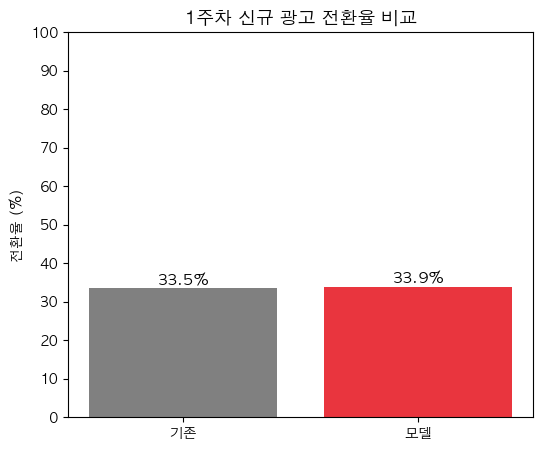

In [50]:
# 기존 전환율 대비, 모델 전환율 비교

# 시각화에 필요한 데이터만 필터링
cvr_graph = model_df.copy()
cvr_graph = cvr_graph.drop(['ads_idx'], axis=1)

# 1주차 광고만 필터링
week1_df = cvr_graph[cvr_graph["week"] == 1].copy()

cat_cols = ['domain','ads_rejoin_type','ads_os_type','mda_idx','ads_3step', 'domain_ads3step', 'domain_mda', 'ads3step_mda', 'domain_os', 'ads3step_os', 'mda_os']
for col in cat_cols:
    if col in week1_df.columns:
        week1_df[col] = week1_df[col].astype("category")

# 모델 예측 전환율
feature_names = lgbm_model.feature_name_  
X_features = week1_df[feature_names]
week1_df['cvr_pred'] = lgbm_model.predict(X_features)

# 전체 평균
mean_actual = week1_df['week_cvr'].mean()
mean_model = week1_df['cvr_pred'].mean()

# 개선율 계산
improvement = (mean_model - mean_actual) / mean_actual * 100

# 값 (% 변환)
mean_actual_pct = mean_actual * 100
mean_model_pct = mean_model * 100
improvement = (mean_model - mean_actual) / mean_actual * 100

# 그래프
fig, ax = plt.subplots(figsize=(6,5))
bars = ax.bar(["기존", "모델"], 
              [mean_actual_pct, mean_model_pct], 
              color=["gray", "#E9353E"])

# 막대 위에 값 표시
for bar, value in zip(bars, [mean_actual_pct, mean_model_pct]):
    ax.text(bar.get_x() + bar.get_width()/2, value, 
            f"{value:.1f}%", ha="center", va="bottom", 
            fontsize=11, fontweight="bold")

# 제목에 개선율 표시
ax.set_title(f"1주차 신규 광고 전환율 비교",
             fontsize=13, fontweight="bold")
ax.set_ylabel("전환율 (%)")

# y축 범위 (0~100%)
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 10))

plt.show()


📊 개선된 광고 비율: 61.54%
📉 악화된 광고 비율: 38.46%
➖ 변화 없음: 0.00%


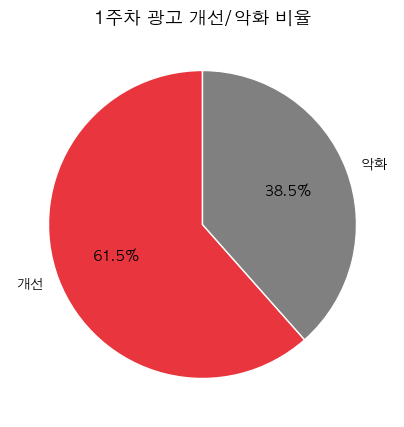

In [51]:
# 개선 vs 악화 비율

# 행 단위 개선 효과 계산
week1_df["improvement"] = week1_df["cvr_pred"] - week1_df["week_cvr"]

# 개선/악화 비율
improved_ratio = (week1_df["improvement"] > 0).mean()
worsened_ratio = (week1_df["improvement"] < 0).mean()
same_ratio = (week1_df["improvement"] == 0).mean()

print(f"📊 개선된 광고 비율: {improved_ratio:.2%}")
print(f"📉 악화된 광고 비율: {worsened_ratio:.2%}")
print(f"➖ 변화 없음: {same_ratio:.2%}")

# 파이차트 (비율 시각화)
labels = ["개선", "악화"]
sizes = [improved_ratio, worsened_ratio]
colors = ["#E9353E", "gray"]

plt.figure(figsize=(5,5))
plt.pie(
    sizes, labels=labels, autopct="%.1f%%", startangle=90, 
    colors=colors, wedgeprops={"edgecolor": "white"}
)
plt.title("1주차 광고 개선/악화 비율", fontsize=13, fontweight="bold")
plt.show()

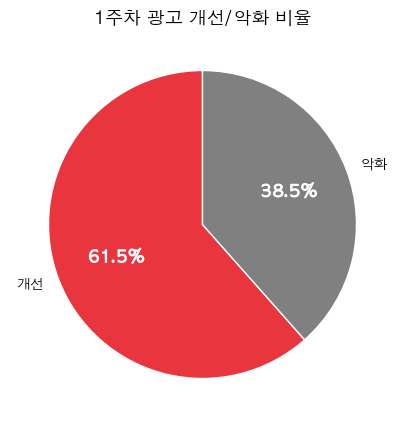

In [71]:
import matplotlib.patheffects as path_effects

labels = ["개선", "악화"]
sizes = [improved_ratio, worsened_ratio]
colors = ["#E9353E", "gray"]

plt.figure(figsize=(5,5))
wedges, texts, autotexts = plt.pie(
    sizes, labels=labels, autopct="%.1f%%", startangle=90,
    colors=colors, wedgeprops={"edgecolor": "white"}
)

# 퍼센트 숫자 스타일 (두껍게 + 윤곽선)
for autotext in autotexts:
    autotext.set_color("white")
    autotext.set_fontweight("black")      # 가장 두껍게
    autotext.set_fontsize(12)             # 크기는 그대로
    # 윤곽선 효과 추가 (검정 테두리)
    autotext.set_path_effects([
        path_effects.Stroke(linewidth=0.8, foreground="white"),
        path_effects.Normal()
    ])

plt.title("1주차 광고 개선/악화 비율", fontsize=13, fontweight="bold")
plt.show()

### 모델 평가 지표_랭킹 성능 지표

In [51]:
from sklearn.metrics import ndcg_score
from scipy.stats import spearmanr

def evaluate_ranking(
    df,
    group_col='domain_ads3step_os',
    y_true_col='true_cvr',
    pred_col='pred_score',
    ks=(1,3,5,10),
    compute_spearman=True
):
    # 안전장치: 필수 컬럼 확인
    for c in [group_col, y_true_col, pred_col]:
        assert c in df.columns, f"Missing column: {c}"
    
    rows = []
    weights = []
    
    for gid, g in df.groupby(group_col, observed=False):
        if len(g) < 2:
            # 랭킹이 성립 안 되는 너무 작은 그룹은 스킵(또는 계속 포함 원하면 처리 변경)
            continue
        
        # numpy 형태
        y_true = g[y_true_col].to_numpy()
        y_pred = g[pred_col].to_numpy()
        
        # 정렬은 필요없고 ndcg_score에는 row shape 필요
        y_true_row = y_true.reshape(1, -1)
        y_pred_row = y_pred.reshape(1, -1)
        
        # Spearman (선택)
        sp = np.nan
        if compute_spearman:
            # 순위로 변환해 스피어만
            tr = pd.Series(y_true).rank(ascending=False, method='first')
            pr = pd.Series(y_pred).rank(ascending=False, method='first')
            sp, _ = spearmanr(tr, pr)
        
        # Hit@K: “실제 1등”이 예측 Top-K 안에 있는지
        true_top_idx = g[y_true_col].idxmax()
        # 예측 점수 내림차순 K개
        g_sorted_pred = g.sort_values(pred_col, ascending=False)
        
        row = {'group_id': gid, 'spearman': sp}
        for k in ks:
            topk_idx = set(g_sorted_pred.head(k).index)
            row[f'hit@{k}'] = 1 if true_top_idx in topk_idx else 0
            row[f'ndcg@{k}'] = ndcg_score(y_true_row, y_pred_row, k=k)
        
        rows.append(row)
        weights.append(len(g))
    
    out = pd.DataFrame(rows)
    if out.empty:
        raise ValueError("No valid groups for evaluation.")
    
    # Macro (그룹 균등 평균)
    macro = out.drop(columns=['group_id']).mean(numeric_only=True).to_dict()
    
    # Weighted (그룹 크기 가중 평균)
    w = np.array(weights)
    w = w / w.sum()
    weighted = {}
    for c in out.columns:
        if c in ('group_id',):
            continue
        weighted[c] = np.average(out[c].to_numpy(), weights=w)
    
    return {'macro': macro, 'weighted': weighted, 'by_group': out}

In [ ]:
# 동일한 테스트 프레임 구성
test_eval_df = test_df[[ 'domain_ads3step_os' ]].copy()
test_eval_df['true_cvr'] = y_test.values
test_eval_df['pred_score'] = ranker_best.predict(X_test)  # 랭커 raw 점수

res = evaluate_ranking(
    test_eval_df,
    group_col='domain_ads3step_os',
    y_true_col='true_cvr',
    pred_col='pred_score',
    ks=(1,3,5,10)
)

print("== Macro (headline) ==")
macro_metrics = {k: round(v,4) for k,v in res['macro'].items()}
print(macro_metrics)

== Macro (headline) ==
{'spearman': 0.063, 'hit@1': 0.3077, 'ndcg@1': 0.5558, 'hit@3': 0.3846, 'ndcg@3': 0.5443, 'hit@5': 0.6154, 'ndcg@5': 0.5941, 'hit@10': 0.6154, 'ndcg@10': 0.6148}
== Weighted (reference) ==
{'spearman': 0.1791, 'hit@1': 0.0776, 'ndcg@1': 0.8692, 'hit@3': 0.0841, 'ndcg@3': 0.8568, 'hit@5': 0.1548, 'ndcg@5': 0.8358, 'hit@10': 0.1548, 'ndcg@10': 0.8184}


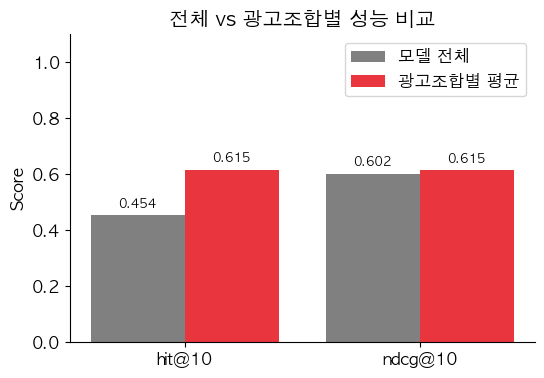

In [107]:
# micro(전체) vs macro(광고단위)

import matplotlib.pyplot as plt

# 성능 결과
overall = {'hit@10': 0.4538, 'ndcg@10': 0.6020}
macro   = {'hit@10': 0.6154, 'ndcg@10': 0.6148}

metrics = list(overall.keys())
x = range(len(metrics))

fig, ax = plt.subplots(figsize=(6,4))

# 막대 그리기
bars1 = ax.bar([i - 0.2 for i in x], [overall[m] for m in metrics], 
               width=0.4, label="모델 전체", color="gray")
bars2 = ax.bar([i + 0.2 for i in x], [macro[m] for m in metrics], 
               width=0.4, label="광고조합별 평균", color="#E9353E")

# 막대 위에 숫자 표시
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, 
                f"{height:.3f}", ha="center", va="bottom", fontsize=9)

# 꾸미기
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0,1.1)
ax.set_ylabel("Score")
ax.set_title("전체 vs 광고조합별 성능 비교")
ax.legend()

plt.show()

